2023.06.06

執行環境：Google Colab

# **期末報告：每股盈餘金額預測 - Random Forest Regressor & XGB Regressor**

以資產負債表、損益表以及現金流量表的會計科目預測 EPS


* 樣本為所有在 2010-2017 年上市櫃之非金融業公司
* X為三表（資產負債表、損益表以及現金流量表）的會計科目，Y為EPS金額
* 預測年月設定:

||訓練資料X|訓練資料y|測試資料X|測試資料y|
|---|---|---|---|---|
|Start|2013 - 2014|2015|2015 - 2016|**2017**|
|End|2014 - 2025|2016|2015 - 2016|**2017**|

---



# **第一部分：使用 Random Forest 和 XGBoost 預測 2017年 的 EPS 金額**

## **0. Setup**

In [ ]:
# Connect to the Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# from sklearn.metrics import roc_curve, roc_auc_score, auc
# from sklearn.model_selection import PredefinedSplit
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import train_test_split

### **Project Path**



In [ ]:
project_path = '/content/gdrive/My Drive/Colab Notebooks/MLAcc/Final'

## **1. 讀取資料集、資料處理**

- 資料期間：2010-2017年

- 資料範圍：2010-2017年上市櫃之非金融業公司

- 資料來源：TEJ Company DB

首先，針對預測變數（Y - 每股盈餘）以及三表中（X - 資產負債表、損益表以及現流表）的資料進行整理，將原始資料整理成模型可以輸入的資料，其中包括：
1. 將資料年份展開 
2. 敘述性統計 
3. 缺失值處理 
4. 資料平減化 
5. 資料合併

### Y - 每股盈餘

In [ ]:
# 匯入資料，並展示資料的前五筆
from google.colab import drive 
drive.mount('/content/gdrive')


eps_row_df = pd.read_excel(os.path.join(project_path, 'EPS_adjusted.xlsx')) 
eps_row_df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,公司,年月,每股盈餘-公司,調整因子,當季底每股盈餘-新報
0,1101 台泥,2017-12-29,2.03,0.809084,2.02
1,1102 亞泥,2017-12-29,1.74,1.000000,1.63
2,1103 嘉泥,2017-12-29,1.39,1.000000,1.39
3,1104 環泥,2017-12-29,2.16,1.000000,2.16
4,1108 幸福,2017-12-29,-0.25,1.000000,-0.25


In [ ]:
# 複製 dataset 來進行資料清理
eps_df = eps_row_df.copy()

In [ ]:
# 將年份單獨列成一欄
eps_df['year'] = eps_df['年月'].apply(lambda x:str(x.year))

In [ ]:
# 由於原始的資料欄位名稱前含有空格，因此使用strip()將空格去除
eps_df.columns = [col.strip() for col in eps_df.columns]

In [ ]:
# 將不需要用到的欄位刪除
eps_df = eps_df.drop(columns=['當季底每股盈餘-新報'])

由於公司於財報中展示的每股盈餘會受到增資、減資或是股票股利等等而不同，在不同年份中有不同的比較基準，因此需要依靠調整因子來達成共同的比較基準。

In [ ]:
# 計算新的欄位即為調整後的每股盈餘（在同比較基準下）
eps_df['adjusted_eps'] = eps_df['每股盈餘-公司'] * eps_df['調整因子']

由於資料目前的主鍵（Primary Key）是採用公司以及年份共同擔任，亦即以公司的欄位來看，會有重複的公司。此部分的目的是將主鍵改成公司欄位單獨擔任，亦即以公司的欄位來看，每間公司都是唯一值。每一筆資料為每一間公司，且都會有好幾個年份的數值，採用pivot()可以達到效果。

In [ ]:
# eps_account為要展開的科目
eps_account = list(set(eps_df.columns)-set(['公司', '年月', 'year', '每股盈餘-公司', '調整因子']))
eps_pivot = eps_df.pivot(index='公司', columns='year', values=eps_account)

# 目前的欄位會分成兩個層級，第一個層級為科目，第二個層級為年份，將兩個層級的名稱合併，並變成一個層級
eps_pivot.columns = ['_'.join(col[::-1]) for col in eps_pivot.columns.values]
eps_pivot.head()

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
公司,,,,,,,,
1101 台泥,1.966074,1.885166,1.690986,2.200708,2.370616,1.262171,1.391624,1.642441
1102 亞泥,2.287190,2.976825,1.855056,3.352941,2.980000,1.550000,1.260000,1.740000
1103 嘉泥,0.574984,0.252427,-1.130000,1.970000,0.030000,0.340000,0.040000,1.390000
1104 環泥,1.838629,0.600557,1.090242,1.700039,2.129853,2.133999,2.601942,2.160000
1108 幸福,-0.460000,-0.350000,0.430000,0.440000,0.940000,1.160000,0.780000,-0.250000


接下來要進行樣本的篩選，第一步要保留自2010年就有數據的公司，且該公司在到2017年為止仍然存續。第二步是將金融業公司從樣本中刪除，因為金融業的很多科目或比率受到較嚴格的監管，納入的話會影響模型的預測。

In [ ]:
# company為保留2010就存在數據且2010-2017仍繼續存在的公司
company = set(eps_df[eps_df['year']=='2010']['公司'])
for year in range(2011, 2018):
    company = company.intersection(set(eps_df[eps_df['year']==str(year)]['公司']))
print('2012存在且2012-2017仍繼續存在的公司:', len(company))

# 刪除金融業（股票代碼前兩碼為28、58或60的公司）
for firm in list(company):
    if firm[:2] in ['28', '58', '60']:
        company.remove(firm)
print('刪除金融業後存在的公司:', len(company))

2012存在且2012-2017仍繼續存在的公司: 1528
刪除金融業後存在的公司: 1484


In [ ]:
eps_pivot = eps_pivot.loc[company].sort_index()
eps_pivot.head()

<ipython-input-13-399c0b8587f4>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  eps_pivot = eps_pivot.loc[company].sort_index()


,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
公司,,,,,,,,
1101 台泥,1.966074,1.885166,1.690986,2.200708,2.370616,1.262171,1.391624,1.642441
1102 亞泥,2.287190,2.976825,1.855056,3.352941,2.980000,1.550000,1.260000,1.740000
1103 嘉泥,0.574984,0.252427,-1.130000,1.970000,0.030000,0.340000,0.040000,1.390000
1104 環泥,1.838629,0.600557,1.090242,1.700039,2.129853,2.133999,2.601942,2.160000
1108 幸福,-0.460000,-0.350000,0.430000,0.440000,0.940000,1.160000,0.780000,-0.250000


針對調整後每股盈餘作敘述性統計，來了解資料的特徵以及發現異常值。

In [ ]:
eps_pivot.describe(percentiles=[.01, .1, .25, .75, .9, .99])

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
count,1480.000000,1482.000000,1483.000000,1484.000000,1483.000000,1484.000000,1482.000000,1484.000000
mean,1.492795,1.360582,1.000314,1.491540,1.795791,1.691272,1.806010,1.928712
std,12.251869,5.285803,6.874235,5.444470,5.692491,6.566902,6.124468,6.426902
min,-307.658374,-78.504126,-161.992015,-92.754958,-55.512345,-57.860000,-43.293338,-30.429126
1%,-12.369071,-13.881743,-16.092778,-11.687498,-11.843952,-12.793059,-9.436762,-7.998337
10%,-0.815185,-1.449895,-1.990744,-1.413829,-1.204263,-1.450000,-1.530000,-1.377000
25%,0.392134,0.139728,0.020065,0.099267,0.265388,0.069727,0.110000,0.108945
50%,1.528427,1.223334,1.027222,1.131669,1.300000,1.178253,1.190000,1.167772
75%,3.188498,2.779063,2.627629,2.904823,3.148819,3.011652,3.090000,2.986364
90%,5.277605,4.703318,4.724322,5.289728,5.592000,5.592783,5.979176,5.895160


從第一列的count可以發現每年的資料量並不一致，也就是說資料中存有少量的缺失值，如下表所示：

In [ ]:
eps_pivot[eps_pivot.isnull().sum(axis=1)!=0]

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
公司,,,,,,,,
2496 卓越,-7.924643,-8.793798,2.863097,-3.527744,-11.861401,-3.272111,NaN,8.105191
3081 聯亞,NaN,2.086669,2.865647,3.355632,7.484946,11.453850,9.640000,7.270000
3276 宇環,-2.381578,-0.600000,-0.060000,0.010000,NaN,0.290000,0.890000,0.490000
6426 統新,NaN,NaN,4.865435,1.988158,2.881389,1.728833,2.670087,2.360898
8028 昇陽半導體,NaN,1.707547,2.481131,4.490565,3.575471,1.481132,NaN,1.349056
8104 錸寶,NaN,NaN,NaN,-17.186576,-10.080588,3.077800,5.700502,6.426576


逐一去看每筆數據的狀況可以發現，除了2496卓越以及3276宇環為資料庫的缺失外，其餘的公司皆為在之後才上市的公司，因此將資料庫的缺失補上，並將其餘的公司從樣本中刪除。

In [ ]:
# 將2496卓越以及3276宇環的缺失補上
eps_pivot.loc['2496 卓越']['2016_adjusted_eps'] = 2.9 * eps_df[(eps_df['公司']=='2496 卓越') & (eps_df['year']=='2016')]['調整因子']
eps_pivot.loc['3276 宇環']['2014_adjusted_eps'] = 1.41 * eps_df[(eps_df['公司']=='3276 宇環') & (eps_df['year']=='2014')]['調整因子']

In [ ]:
# 將其餘含有缺失值的公司刪除
eps_pivot.dropna(inplace=True)

In [ ]:
# 確認是否還有缺失值
eps_pivot[eps_pivot.isnull().sum(axis=1)!=0]

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
公司,,,,,,,,


接下來針對三表中的資料進行整理，其流程與Y類似。

### X - 資產負債表科目

In [ ]:
# 匯入資料，並展示資料的前五筆
bs_df = pd.read_excel(os.path.join(project_path, 'BS.xlsx'))

bs_df.head()

,公司,年月,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,其他應收款,...,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,股東權益總額,負債及股東權益總額
0,1101 台泥,2017-12-29,26331218.0,147049.0,25101220.0,0.0,0.0,0.0,27306164.0,755024.0,...,21944766.0,49019510.0,19124539.0,0.0,136348204.0,0.0,0.0,16299012.0,152647216,272557049
1,1102 亞泥,2017-12-29,7739492.0,322080.0,7805406.0,4380928.0,0.0,0.0,18266303.0,3042831.0,...,16125837.0,94196274.0,-1543873.0,0.0,127435565.0,0.0,0.0,18360799.0,145796364,247064348
2,1103 嘉泥,2017-12-29,1803189.0,507148.0,2543683.0,0.0,0.0,0.0,206738.0,65394.0,...,4638766.0,9074455.0,1196784.0,-1149426.0,17511786.0,0.0,0.0,1749054.0,19260840,28317986
3,1104 環泥,2017-12-29,192742.0,0.0,2226289.0,0.0,0.0,0.0,1012020.0,6841.0,...,4793003.0,10109852.0,344008.0,0.0,17036903.0,0.0,0.0,117858.0,17154761,21229208
4,1108 幸福,2017-12-29,251893.0,0.0,151476.0,0.0,0.0,0.0,599362.0,3514.0,...,177528.0,357972.0,-3241.0,0.0,4402119.0,0.0,0.0,26423.0,4428542,7236852


In [ ]:
# 將年份單獨列成一欄
bs_df['year'] = bs_df['年月'].apply(lambda x:str(x.year))

In [ ]:
# 將不需要的列去除
bs_df = bs_df[bs_df['year']!='2010']

In [ ]:
# 由於原始的資料欄位名稱前含有空格，因此使用strip()將空格去除
bs_df.columns = [col.strip() for col in bs_df.columns]

接下來對資料進行平減化，由於每個科目的規模相差甚遠，因此採用資產總額對其平減。

In [ ]:
# 將每筆資料除以總資產，採用div()，但由於除數不能用於字符串，因此先將該欄位去除，後續計算完成再利用concat()拼接回去。
tmp = bs_df['資產總額']
bs_df = pd.concat([bs_df[['公司','年月','year']], bs_df.drop(columns=['公司','年月','year']).div(bs_df['資產總額'], axis='rows')], axis=1)
bs_df['資產總額'] = tmp
bs_df.head()

,公司,年月,year,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,...,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,共同控制下前手權益,合併前非屬共同控制股權,非控制權益,股東權益總額,負債及股東權益總額
0,1101 台泥,2017-12-29,2017,0.096608,0.000540,0.092095,0.000000,0.0,0.0,0.100185,...,0.080514,0.179850,0.070167,0.00000,0.500256,0.0,0.0,0.059800,0.560056,1.0
1,1102 亞泥,2017-12-29,2017,0.031326,0.001304,0.031593,0.017732,0.0,0.0,0.073933,...,0.065270,0.381262,-0.006249,0.00000,0.515799,0.0,0.0,0.074316,0.590115,1.0
2,1103 嘉泥,2017-12-29,2017,0.063676,0.017909,0.089826,0.000000,0.0,0.0,0.007301,...,0.163810,0.320448,0.042262,-0.04059,0.618398,0.0,0.0,0.061765,0.680163,1.0
3,1104 環泥,2017-12-29,2017,0.009079,0.000000,0.104869,0.000000,0.0,0.0,0.047671,...,0.225774,0.476224,0.016204,0.00000,0.802522,0.0,0.0,0.005552,0.808074,1.0
4,1108 幸福,2017-12-29,2017,0.034807,0.000000,0.020931,0.000000,0.0,0.0,0.082821,...,0.024531,0.049465,-0.000448,0.00000,0.608292,0.0,0.0,0.003651,0.611943,1.0


如同EPS，由於資料目前的主鍵（Primary Key）是採用公司以及年份共同擔任，亦即以公司的欄位來看，會有重複的公司。此部分的目的是將主鍵改成公司欄位單獨擔任，亦即以公司的欄位來看，每間公司都是唯一值。每一筆資料為每一間公司，且都會有好幾個年份的數值，採用pivot()可以達到效果。

In [ ]:
# bs_account為要展開的科目（其中將可能共線的變數刪除）
bs_account = list(set(bs_df.columns)-set(['公司', '年月', 'year', '流動資產', '非流動資產', '資產總額', '流動負債',
                                         '非流動負債', '負債總額', '股東權益總額', '負債及股東權益總額']))
bs_pivot = bs_df.pivot(index='公司', columns='year', values=bs_account)

# 目前的欄位會分成兩個層級，第一個層級為科目，第二個層級為年份，將兩個層級的名稱合併，並變成一個層級
bs_pivot.columns = ['_'.join(col[::-1]) for col in bs_pivot.columns.values]
bs_pivot.head()

,2011_特別股股本,2012_特別股股本,2013_特別股股本,2014_特別股股本,2015_特別股股本,2016_特別股股本,2017_特別股股本,2011_租賃負債─流動,2012_租賃負債─流動,2013_租賃負債─流動,...,2015_普通股股本,2016_普通股股本,2017_普通股股本,2011_不動產廠房及設備,2012_不動產廠房及設備,2013_不動產廠房及設備,2014_不動產廠房及設備,2015_不動產廠房及設備,2016_不動產廠房及設備,2017_不動產廠房及設備
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.125984,0.138290,0.155803,0.559333,0.380689,0.386902,0.370445,0.386636,0.381289,0.347485
1102 亞泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.124462,0.140958,0.136056,0.378511,0.236340,0.238114,0.249581,0.249057,0.246707,0.217509
1103 嘉泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.283690,0.296522,0.273600,0.366279,0.129521,0.108336,0.091661,0.085316,0.077548,0.100725
1104 環泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.314603,0.311873,0.307882,0.257907,0.360857,0.329457,0.295945,0.279789,0.281046,0.278051
1108 幸福,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.515229,0.522064,0.559274,0.306312,0.307872,0.283735,0.275033,0.274629,0.245044,0.227801


接下來進行樣本的篩選，利用前面整理Y變數（更新缺失值去除的部分）去更新company變數。

In [ ]:
company = list(eps_pivot.index)

In [ ]:
bs_pivot = bs_pivot.loc[company].sort_index()
bs_pivot.head()

,2011_特別股股本,2012_特別股股本,2013_特別股股本,2014_特別股股本,2015_特別股股本,2016_特別股股本,2017_特別股股本,2011_租賃負債─流動,2012_租賃負債─流動,2013_租賃負債─流動,...,2015_普通股股本,2016_普通股股本,2017_普通股股本,2011_不動產廠房及設備,2012_不動產廠房及設備,2013_不動產廠房及設備,2014_不動產廠房及設備,2015_不動產廠房及設備,2016_不動產廠房及設備,2017_不動產廠房及設備
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.125984,0.138290,0.155803,0.559333,0.380689,0.386902,0.370445,0.386636,0.381289,0.347485
1102 亞泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.124462,0.140958,0.136056,0.378511,0.236340,0.238114,0.249581,0.249057,0.246707,0.217509
1103 嘉泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.283690,0.296522,0.273600,0.366279,0.129521,0.108336,0.091661,0.085316,0.077548,0.100725
1104 環泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.314603,0.311873,0.307882,0.257907,0.360857,0.329457,0.295945,0.279789,0.281046,0.278051
1108 幸福,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.515229,0.522064,0.559274,0.306312,0.307872,0.283735,0.275033,0.274629,0.245044,0.227801


針對資產負債表科目做敘述性統計，來了解資料的特徵以及發現異常值。

In [ ]:
bs_pivot.describe(percentiles=[.01, .1, .25, .75, .9, .99])

,2011_特別股股本,2012_特別股股本,2013_特別股股本,2014_特別股股本,2015_特別股股本,2016_特別股股本,2017_特別股股本,2011_租賃負債─流動,2012_租賃負債─流動,2013_租賃負債─流動,...,2015_普通股股本,2016_普通股股本,2017_普通股股本,2011_不動產廠房及設備,2012_不動產廠房及設備,2013_不動產廠房及設備,2014_不動產廠房及設備,2015_不動產廠房及設備,2016_不動產廠房及設備,2017_不動產廠房及設備
count,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,0.0,0.0,0.0,...,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000
mean,0.000834,0.001466,0.004587,0.000917,0.000908,0.000782,0.001012,NaN,NaN,NaN,...,0.385633,0.398442,0.410553,0.284199,0.269284,0.264275,0.259785,0.261465,0.256327,0.254728
std,0.021580,0.035342,0.149694,0.033022,0.034693,0.029879,0.038715,NaN,NaN,NaN,...,0.483400,1.095479,1.472230,0.185163,0.180690,0.179912,0.176484,0.178951,0.179104,0.179724
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.007751,0.007384,0.007137,0.000085,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.056701,0.059369,0.048434,0.002286,0.000770,0.000685,0.000500,0.000511,0.000382,0.000490
10%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.133229,0.128554,0.122502,0.043359,0.037890,0.037310,0.035127,0.033851,0.033681,0.031613
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.200161,0.194944,0.185386,0.136495,0.125332,0.127603,0.122665,0.124050,0.116041,0.115723
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.303597,0.300906,0.297242,0.267469,0.252103,0.245118,0.240431,0.237044,0.231867,0.229193
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.455475,0.454935,0.450568,0.411549,0.386983,0.384925,0.373089,0.373055,0.372481,0.365687
90%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.654256,0.665835,0.657858,0.530147,0.508605,0.507489,0.499185,0.511444,0.500663,0.507752


若要分年度展示，可以先將column進行排序，再進行敘述性統計，採用sort_index(axis=1)。

In [ ]:
bs_pivot.sort_index(axis=1).describe(percentiles=[.01, .1, .25, .75, .9, .99])

,2011_一年內到期長期負債,2011_不動產廠房及設備,2011_使用權資產,2011_保留盈餘,2011_共同控制下前手權益,2011_其他應付款,2011_其他應收款,2011_其他權益,2011_其他長期借款－非流動,2011_其他非流動資產,...,2017_遞延貸項,2017_遞延資產合計,2017_避險之金融負債－流動,2017_避險之金融負債－非流動,2017_避險之金融資產－流動,2017_避險之金融資產－非流動,2017_銀行借款－非流動,2017_非控制權益,2017_預付投資款,2017_預收股款
count,1480.000000,1480.000000,0.0,1480.000000,1478.0,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,...,1480.000000,1480.000000,1480.000000,1.480000e+03,1480.000000,1.480000e+03,1480.000000,1480.000000,1480.000000,1480.000000
mean,0.020085,0.284199,NaN,0.034362,0.0,0.049826,0.008324,0.013817,0.001890,0.034316,...,0.000002,0.010748,0.000012,2.337516e-07,0.000008,3.040957e-07,0.062615,0.019582,0.000245,0.000331
std,0.039356,0.185163,NaN,0.959092,0.0,0.045971,0.033108,0.079051,0.011713,0.072405,...,0.000044,0.015858,0.000253,8.226736e-06,0.000208,8.785886e-06,0.098371,0.043145,0.002731,0.006999
min,0.000000,0.000085,NaN,-31.671830,0.0,0.000000,0.000000,-2.294233,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,-0.173352,0.000000,0.000000
1%,0.000000,0.002286,NaN,-1.281245,0.0,0.000000,0.000000,-0.065249,0.000000,0.000008,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,-0.003210,0.000000,0.000000
10%,0.000000,0.043359,NaN,-0.115341,0.0,0.011178,0.000000,-0.012153,0.000000,0.001214,...,0.000000,0.000039,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.136495,NaN,0.024581,0.0,0.023890,0.000000,-0.001166,0.000000,0.003449,...,0.000000,0.002315,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,0.002462,0.267469,NaN,0.104696,0.0,0.041470,0.001759,0.003000,0.000000,0.010794,...,0.000000,0.006443,0.000000,0.000000e+00,0.000000,0.000000e+00,0.010351,0.000026,0.000000,0.000000
75%,0.023659,0.411549,NaN,0.190599,0.0,0.064097,0.006739,0.021642,0.000000,0.034185,...,0.000000,0.013240,0.000000,0.000000e+00,0.000000,0.000000e+00,0.093619,0.019055,0.000000,0.000000
90%,0.062122,0.530147,NaN,0.284081,0.0,0.091249,0.017697,0.051499,0.000254,0.080453,...,0.000000,0.026000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.200881,0.067096,0.000000,0.000000


從敘述性統計中可以發現有些欄位是整欄都是缺失值，經查證該科目為2017年以後IFRS9以及IFRS15才使用的科目（例如：合約資產、合約負債以及使用權資產等等），可以直接將該科目刪除。其餘的缺失值則視為公司沒有該科目，即補數值0。

In [ ]:
# 當欄位全部為缺失值時將其刪除
bs_pivot.dropna(axis=1, how='all', inplace=True)

In [ ]:
# 將所有缺失值補為0
bs_pivot.fillna(0, inplace=True)

In [ ]:
# 確認是否還有缺失值
bs_pivot[bs_pivot.isnull().sum(axis=1)!=0]

,2011_特別股股本,2012_特別股股本,2013_特別股股本,2014_特別股股本,2015_特別股股本,2016_特別股股本,2017_特別股股本,2011_與待出售非流動資產直接相關之負債,2012_與待出售非流動資產直接相關之負債,2013_與待出售非流動資產直接相關之負債,...,2015_普通股股本,2016_普通股股本,2017_普通股股本,2011_不動產廠房及設備,2012_不動產廠房及設備,2013_不動產廠房及設備,2014_不動產廠房及設備,2015_不動產廠房及設備,2016_不動產廠房及設備,2017_不動產廠房及設備
公司,,,,,,,,,,,,,,,,,,,,,


### X - 損益表科目

In [ ]:
# 匯入資料，並展示資料的前五筆
is_df = pd.read_excel(os.path.join(project_path, 'IS.xlsx'))
is_df.head()

,公司,年月,營業收入淨額,營業成本,營業毛利,聯屬公司已（未）實現銷貨利益,已實現銷貨毛利,營業費用,研究發展費,預期信用減損（損失）利益－營業費用,...,綜合損益歸屬母公司,綜合損益歸屬非控制權益,綜合損益歸屬共同控制下前手權益,加權平均股數,發放特別股股息,稀釋稅後淨利,加權平均股數－稀釋,稅前息前淨利,稅前息前折舊前淨利,常續性稅後淨利
0,1101 台泥,2017-12-29,98311776.0,79398862.0,18912914.0,0.0,18912914.0,4950029.0,32399.0,NaN,...,17775812.0,2523760.0,0.0,3738370.0,0.0,7594247.0,3739270.0,15747968.0,22211761.0,10983992.0
1,1102 亞泥,2017-12-29,69700034.0,59529016.0,10171018.0,-540.0,10170478.0,2733762.0,0.0,NaN,...,7895746.0,889334.0,0.0,3139297.0,0.0,5470384.0,3147654.0,10271234.0,15448825.0,6581964.0
2,1103 嘉泥,2017-12-29,2095607.0,1813286.0,282321.0,0.0,282321.0,511805.0,0.0,NaN,...,3538372.0,164255.0,0.0,643555.0,0.0,895198.0,644300.0,1182543.0,1539621.0,-307313.0
3,1104 環泥,2017-12-29,4405376.0,3867468.0,537908.0,0.0,537908.0,387681.0,85467.0,NaN,...,1533947.0,-22487.0,0.0,653609.0,0.0,1411666.0,654879.0,1442996.0,1546607.0,1360132.0
4,1108 幸福,2017-12-29,3434454.0,3305953.0,128501.0,0.0,128501.0,221218.0,0.0,NaN,...,-126733.0,-1968.0,0.0,404738.0,0.0,-101111.0,404738.0,-88278.0,189652.0,-101866.0


In [ ]:
# 將年份單獨列成一欄
is_df['year'] = is_df['年月'].apply(lambda x:str(x.year))

In [ ]:
# 由於原始的資料欄位名稱前含有空格，因此使用strip()將空格去除
is_df.columns = [col.strip() for col in is_df.columns]

接下來對資料進行平減化，由於每個科目的規模相差甚遠，因此採用營業收入淨額對其平減。

In [ ]:
# 將每筆資料除以營業收入，採用div()，但由於除數不能用於字符串，因此先將該欄位去除，後續計算完成再利用concat()拼接回去。
is_df = pd.concat([is_df[['公司','年月','year']], is_df.drop(columns=['公司','年月','year']).div(is_df['營業收入淨額'], axis='rows')], axis=1)
is_df.head()

,公司,年月,year,營業收入淨額,營業成本,營業毛利,聯屬公司已（未）實現銷貨利益,已實現銷貨毛利,營業費用,研究發展費,...,綜合損益歸屬母公司,綜合損益歸屬非控制權益,綜合損益歸屬共同控制下前手權益,加權平均股數,發放特別股股息,稀釋稅後淨利,加權平均股數－稀釋,稅前息前淨利,稅前息前折舊前淨利,常續性稅後淨利
0,1101 台泥,2017-12-29,2017,1.0,0.807623,0.192377,0.000000,0.192377,0.050350,0.000330,...,0.180811,0.025671,0.0,0.038026,0.0,0.077247,0.038035,0.160184,0.225932,0.111726
1,1102 亞泥,2017-12-29,2017,1.0,0.854074,0.145926,-0.000008,0.145918,0.039222,0.000000,...,0.113282,0.012759,0.0,0.045040,0.0,0.078485,0.045160,0.147363,0.221647,0.094433
2,1103 嘉泥,2017-12-29,2017,1.0,0.865280,0.134720,0.000000,0.134720,0.244228,0.000000,...,1.688471,0.078381,0.0,0.307097,0.0,0.427178,0.307453,0.564296,0.734690,-0.146646
3,1104 環泥,2017-12-29,2017,1.0,0.877897,0.122103,0.000000,0.122103,0.088002,0.019401,...,0.348199,-0.005104,0.0,0.148366,0.0,0.320442,0.148655,0.327553,0.351073,0.308744
4,1108 幸福,2017-12-29,2017,1.0,0.962585,0.037415,0.000000,0.037415,0.064411,0.000000,...,-0.036900,-0.000573,0.0,0.117846,0.0,-0.029440,0.117846,-0.025704,0.055220,-0.029660


如同EPS，由於資料目前的主鍵（Primary Key）是採用公司以及年份共同擔任，亦即以公司的欄位來看，會有重複的公司。此部分的目的是將主鍵改成公司欄位單獨擔任，亦即以公司的欄位來看，每間公司都是唯一值。每一筆資料為每一間公司，且都會有好幾個年份的數值，採用pivot()可以達到效果。

In [ ]:
# is_account為要展開的科目（其中將可能共線的變數刪除）
is_account = list(set(is_df.columns)-set(['公司', '年月', 'year', '營業收入淨額', '營業利益', '營業外收入及支出', '稅前淨利',
                                         '合併總損益', '本期綜合損益總額', '加權平均股數', '加權平均股數－稀釋', '稅前息前淨利',
                                         '稅前息前折舊前淨利']))
is_pivot = is_df.pivot(index='公司', columns='year', values=is_account)

# 目前的欄位會分成兩個層級，第一個層級為科目，第二個層級為年份，將兩個層級的名稱合併，並變成一個層級
is_pivot.columns = ['_'.join(col[::-1]) for col in is_pivot.columns.values]
is_pivot.head()

,2012_其他收益及費損淨額,2013_其他收益及費損淨額,2014_其他收益及費損淨額,2015_其他收益及費損淨額,2016_其他收益及費損淨額,2017_其他收益及費損淨額,2012_金融資產重分類淨損益,2013_金融資產重分類淨損益,2014_金融資產重分類淨損益,2015_金融資產重分類淨損益,...,2014_預期信用減損（損失）利益－營業費用,2015_預期信用減損（損失）利益－營業費用,2016_預期信用減損（損失）利益－營業費用,2017_預期信用減損（損失）利益－營業費用,2012_財務成本,2013_財務成本,2014_財務成本,2015_財務成本,2016_財務成本,2017_財務成本
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.023954,0.016454,0.016118,0.020002,0.021402,0.019563
1102 亞泥,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.027805,0.023374,0.021467,0.024859,0.026880,0.025424
1103 嘉泥,0.0,0.153356,0.000000,0.346884,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.035613,0.040141,0.049031,0.080037,0.061025,0.048196
1104 環泥,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000532,0.001293,0.001743,0.002826,0.003620,0.004036
1108 幸福,0.0,0.000000,0.000012,0.000003,0.000025,-0.002221,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.019170,0.014241,0.011094,0.008489,0.007349,0.008948


接下來進行樣本的篩選，利用前面整理X變數更新得到的company變數。

In [ ]:
is_pivot = is_pivot.loc[company].sort_index()
is_pivot.head()

,2012_其他收益及費損淨額,2013_其他收益及費損淨額,2014_其他收益及費損淨額,2015_其他收益及費損淨額,2016_其他收益及費損淨額,2017_其他收益及費損淨額,2012_金融資產重分類淨損益,2013_金融資產重分類淨損益,2014_金融資產重分類淨損益,2015_金融資產重分類淨損益,...,2014_預期信用減損（損失）利益－營業費用,2015_預期信用減損（損失）利益－營業費用,2016_預期信用減損（損失）利益－營業費用,2017_預期信用減損（損失）利益－營業費用,2012_財務成本,2013_財務成本,2014_財務成本,2015_財務成本,2016_財務成本,2017_財務成本
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.023954,0.016454,0.016118,0.020002,0.021402,0.019563
1102 亞泥,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.027805,0.023374,0.021467,0.024859,0.026880,0.025424
1103 嘉泥,0.0,0.153356,0.000000,0.346884,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.035613,0.040141,0.049031,0.080037,0.061025,0.048196
1104 環泥,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000532,0.001293,0.001743,0.002826,0.003620,0.004036
1108 幸福,0.0,0.000000,0.000012,0.000003,0.000025,-0.002221,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.019170,0.014241,0.011094,0.008489,0.007349,0.008948


針對損益表科目做敘述性統計，來了解資料的特徵以及發現異常值。

In [ ]:
is_pivot.describe(percentiles=[.01, .1, .25, .75, .9, .99])

,2012_其他收益及費損淨額,2013_其他收益及費損淨額,2014_其他收益及費損淨額,2015_其他收益及費損淨額,2016_其他收益及費損淨額,2017_其他收益及費損淨額,2012_金融資產重分類淨損益,2013_金融資產重分類淨損益,2014_金融資產重分類淨損益,2015_金融資產重分類淨損益,...,2014_預期信用減損（損失）利益－營業費用,2015_預期信用減損（損失）利益－營業費用,2016_預期信用減損（損失）利益－營業費用,2017_預期信用減損（損失）利益－營業費用,2012_財務成本,2013_財務成本,2014_財務成本,2015_財務成本,2016_財務成本,2017_財務成本
count,1466.000000,1468.000000,1477.000000,1478.000000,1480.000000,1480.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.000000,1477.000000,1477.000000,1477.000000,1478.000000,1480.000000,1480.000000
mean,-0.000310,0.002957,0.001149,0.000923,-0.000731,-0.000128,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001222,0.037500,0.014509,0.012594,0.020154,0.012420,0.015196
std,0.030666,0.061106,0.019190,0.014795,0.032375,0.027848,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003768,1.038504,0.249160,0.107406,0.389905,0.095710,0.108578
min,-0.900194,-0.643090,-0.059761,-0.105312,-1.152019,-0.870453,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.007946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,-0.003828,-0.005670,-0.002915,-0.001198,-0.003158,-0.002395,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.007187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.000358,0.000014,0.000023,0.000007,0.000005,0.000003,0.000011
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.000021,0.000781,0.000756,0.000790,0.000733,0.000720,0.000778
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001040,0.003322,0.003209,0.003189,0.003280,0.003195,0.003306
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003276,0.008495,0.008205,0.008216,0.008413,0.008646,0.008417
90%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.004567,0.018038,0.018297,0.017884,0.020219,0.020454,0.020167


從敘述性統計中可以發現有些欄位是整欄都是缺失值，經查證該科目為2017年以後IFRS9以及IFRS15才使用的科目（例如：合約資產、合約負債以及使用權資產等等），可以直接將該科目刪除。其餘的缺失值則視為公司沒有該科目，即補數值0。

In [ ]:
# 當欄位全部為缺失值時將其刪除
is_pivot.dropna(axis=1, how='all', inplace=True)

In [ ]:
# 將所有缺失值補為0
is_pivot.fillna(0, inplace=True)

In [ ]:
# 確認是否還有缺失值
is_pivot[is_pivot.isnull().sum(axis=1)!=0]

,2012_其他收益及費損淨額,2013_其他收益及費損淨額,2014_其他收益及費損淨額,2015_其他收益及費損淨額,2016_其他收益及費損淨額,2017_其他收益及費損淨額,2012_綜合損益歸屬母公司,2013_綜合損益歸屬母公司,2014_綜合損益歸屬母公司,2015_綜合損益歸屬母公司,...,2015_歸屬共同控制下前手權益淨利（損）,2016_歸屬共同控制下前手權益淨利（損）,2017_歸屬共同控制下前手權益淨利（損）,2017_預期信用減損（損失）利益－營業費用,2012_財務成本,2013_財務成本,2014_財務成本,2015_財務成本,2016_財務成本,2017_財務成本
公司,,,,,,,,,,,,,,,,,,,,,


另外，從敘述性統計中發現有些值為inf，經查證發現主要原因為沒有營收資料，因此當營收為分母時導致科目為inf，將該公司的資料直接刪除。

In [ ]:
# 判斷哪些公司有年度缺少營收資料
set(is_pivot[np.isinf(is_pivot).values].index)

{'4147 中裕', '4174 浩鼎', '4188 安克', '4192 杏國'}

In [ ]:
is_pivot.drop(list(set(is_pivot[np.isinf(is_pivot).values].index)), inplace=True)

### X - 現金流量表科目

In [ ]:
# 匯入資料，並展示資料的前五筆
cf_df = pd.read_excel(os.path.join(project_path, 'CF.xlsx'))
cf_df.head()

,公司,年月,來自營運之現金流量,投資活動之現金流量,籌資活動之現金流量
0,1101 台泥,2017-12-29,12310560.0,1055604.0,-14892479.0
1,1102 亞泥,2017-12-29,8139048.0,-6784797.0,-779555.0
2,1103 嘉泥,2017-12-29,403390.0,124980.0,-950610.0
3,1104 環泥,2017-12-29,646339.0,-180463.0,-470396.0
4,1108 幸福,2017-12-29,81037.0,249673.0,-291609.0


In [ ]:
# 將年份單獨列成一欄
cf_df['year'] = cf_df['年月'].apply(lambda x:str(x.year))

In [ ]:
# 由於原始的資料欄位名稱前含有空格，因此使用strip()將空格去除
cf_df.columns = [col.strip() for col in cf_df.columns]

接下來對資料進行平減化，由於每個科目的規模相差甚遠，因此採用資產總額對其平減。

In [ ]:
cf_df = pd.merge(cf_df, bs_df[['公司', 'year', '資產總額']], on=['公司', 'year'], how='left')

In [ ]:
# 將每筆資料除以資產總額，採用div()，但由於除數不能用於字符串，因此先將該欄位去除，後續計算完成再利用concat()拼接回去。
pd.concat([cf_df[['公司','年月','year']], cf_df.drop(columns=['公司','年月','year']).div(cf_df['資產總額'], axis='rows')], axis=1)

,公司,年月,year,來自營運之現金流量,投資活動之現金流量,籌資活動之現金流量,資產總額
0,1101 台泥,2017-12-29,2017,0.045167,0.003873,-0.054640,1.0
1,1102 亞泥,2017-12-29,2017,0.032943,-0.027462,-0.003155,1.0
2,1103 嘉泥,2017-12-29,2017,0.014245,0.004413,-0.033569,1.0
3,1104 環泥,2017-12-29,2017,0.030446,-0.008501,-0.022158,1.0
4,1108 幸福,2017-12-29,2017,0.011198,0.034500,-0.040295,1.0
...,...,...,...,...,...,...,...
10275,9951 皇田,2012-12-28,2012,0.156052,0.009314,-0.124012,1.0
10276,9955 佳龍,2012-12-28,2012,0.098862,-0.072931,-0.020909,1.0
10277,9958 世紀鋼,2012-12-28,2012,-0.043691,-0.042862,0.078335,1.0
10278,9960 邁達康,2012-12-28,2012,0.056004,0.056308,-0.000316,1.0


如同EPS，由於資料目前的主鍵（Primary Key）是採用公司以及年份共同擔任，亦即以公司的欄位來看，會有重複的公司。此部分的目的是將主鍵改成公司欄位單獨擔任，亦即以公司的欄位來看，每間公司都是唯一值。每一筆資料為每一間公司，且都會有好幾個年份的數值，採用pivot()可以達到效果。

In [ ]:
# cf_account為要展開的科目
cf_account = list(set(cf_df.columns)-set(['公司', '年月', 'year', '資產總額']))

# 目前的欄位會分成兩個層級，第一個層級為科目，第二個層級為年份，將兩個層級的名稱合併，並變成一個層級
cf_pivot = cf_df.pivot(index='公司', columns='year', values=cf_account)
cf_pivot.columns = ['_'.join(col[::-1]) for col in cf_pivot.columns.values]
cf_pivot.head()

,2012_來自營運之現金流量,2013_來自營運之現金流量,2014_來自營運之現金流量,2015_來自營運之現金流量,2016_來自營運之現金流量,2017_來自營運之現金流量,2012_投資活動之現金流量,2013_投資活動之現金流量,2014_投資活動之現金流量,2015_投資活動之現金流量,2016_投資活動之現金流量,2017_投資活動之現金流量,2012_籌資活動之現金流量,2013_籌資活動之現金流量,2014_籌資活動之現金流量,2015_籌資活動之現金流量,2016_籌資活動之現金流量,2017_籌資活動之現金流量
公司,,,,,,,,,,,,,,,,,,
1101 台泥,25434756.0,21973605.0,19904673.0,21763392.0,18750155.0,12310560.0,-9932035.0,-1248644.0,-3015765.0,-7833403.0,54767.0,1055604.0,-12251656.0,-20772849.0,-11730774.0,-5046590.0,-28895952.0,-14892479.0
1102 亞泥,14167455.0,14781266.0,10642592.0,13592303.0,12817431.0,8139048.0,-8961889.0,-11256192.0,-12619151.0,-2360243.0,2330984.0,-6784797.0,-7515198.0,6919806.0,-4566862.0,-12987242.0,-18325536.0,-779555.0
1103 嘉泥,748670.0,-727919.0,463080.0,303390.0,414899.0,403390.0,-1363371.0,881881.0,-2234527.0,-775173.0,3214197.0,124980.0,889464.0,-1198763.0,1561084.0,-925916.0,-3066744.0,-950610.0
1104 環泥,74512.0,548411.0,659966.0,847608.0,741025.0,646339.0,-172185.0,-417900.0,-470658.0,-613010.0,-444014.0,-180463.0,-338532.0,43120.0,-222743.0,-235576.0,-494776.0,-470396.0
1108 幸福,273329.0,621452.0,831155.0,1018144.0,246301.0,81037.0,129371.0,-96894.0,-199779.0,-134964.0,-260675.0,249673.0,-437045.0,-403822.0,-588616.0,-924963.0,7594.0,-291609.0


接下來進行樣本的篩選，利用前面整理X變數更新得到的company變數。

In [ ]:
cf_pivot = cf_pivot.loc[company].sort_index()
cf_pivot.head()

,2012_來自營運之現金流量,2013_來自營運之現金流量,2014_來自營運之現金流量,2015_來自營運之現金流量,2016_來自營運之現金流量,2017_來自營運之現金流量,2012_投資活動之現金流量,2013_投資活動之現金流量,2014_投資活動之現金流量,2015_投資活動之現金流量,2016_投資活動之現金流量,2017_投資活動之現金流量,2012_籌資活動之現金流量,2013_籌資活動之現金流量,2014_籌資活動之現金流量,2015_籌資活動之現金流量,2016_籌資活動之現金流量,2017_籌資活動之現金流量
公司,,,,,,,,,,,,,,,,,,
1101 台泥,25434756.0,21973605.0,19904673.0,21763392.0,18750155.0,12310560.0,-9932035.0,-1248644.0,-3015765.0,-7833403.0,54767.0,1055604.0,-12251656.0,-20772849.0,-11730774.0,-5046590.0,-28895952.0,-14892479.0
1102 亞泥,14167455.0,14781266.0,10642592.0,13592303.0,12817431.0,8139048.0,-8961889.0,-11256192.0,-12619151.0,-2360243.0,2330984.0,-6784797.0,-7515198.0,6919806.0,-4566862.0,-12987242.0,-18325536.0,-779555.0
1103 嘉泥,748670.0,-727919.0,463080.0,303390.0,414899.0,403390.0,-1363371.0,881881.0,-2234527.0,-775173.0,3214197.0,124980.0,889464.0,-1198763.0,1561084.0,-925916.0,-3066744.0,-950610.0
1104 環泥,74512.0,548411.0,659966.0,847608.0,741025.0,646339.0,-172185.0,-417900.0,-470658.0,-613010.0,-444014.0,-180463.0,-338532.0,43120.0,-222743.0,-235576.0,-494776.0,-470396.0
1108 幸福,273329.0,621452.0,831155.0,1018144.0,246301.0,81037.0,129371.0,-96894.0,-199779.0,-134964.0,-260675.0,249673.0,-437045.0,-403822.0,-588616.0,-924963.0,7594.0,-291609.0


針對現金流量表科目做敘述性統計，來了解資料的特徵以及發現異常值。

In [ ]:
cf_pivot.describe(percentiles=[.01, .1, .25, .75, .9, .99])

,2012_來自營運之現金流量,2013_來自營運之現金流量,2014_來自營運之現金流量,2015_來自營運之現金流量,2016_來自營運之現金流量,2017_來自營運之現金流量,2012_投資活動之現金流量,2013_投資活動之現金流量,2014_投資活動之現金流量,2015_投資活動之現金流量,2016_投資活動之現金流量,2017_投資活動之現金流量,2012_籌資活動之現金流量,2013_籌資活動之現金流量,2014_籌資活動之現金流量,2015_籌資活動之現金流量,2016_籌資活動之現金流量,2017_籌資活動之現金流量
count,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03,1.480000e+03
mean,1.444428e+06,1.590817e+06,1.645593e+06,1.937653e+06,1.950274e+06,1.581852e+06,-1.053198e+06,-1.136134e+06,-1.095402e+06,-1.018648e+06,-1.239269e+06,-1.129196e+06,-2.118447e+05,-1.217984e+05,-3.446984e+05,-8.148838e+05,-5.452306e+05,-3.260980e+05
std,1.005254e+07,1.156306e+07,1.347157e+07,1.649906e+07,1.613425e+07,1.659898e+07,8.060079e+06,8.959425e+06,8.625812e+06,7.008859e+06,1.270705e+07,1.004361e+07,4.385962e+06,3.381040e+06,5.387473e+06,7.463436e+06,5.988675e+06,8.290956e+06
min,-1.749644e+07,-1.623146e+07,-1.342420e+07,-1.305248e+07,-1.340052e+07,-3.934131e+07,-2.693177e+08,-2.810542e+08,-2.824206e+08,-2.172458e+08,-3.954397e+08,-3.361649e+08,-1.081457e+08,-6.066204e+07,-1.582185e+08,-1.911784e+08,-1.578002e+08,-2.156976e+08
1%,-2.040972e+06,-2.223975e+06,-2.847562e+06,-1.594716e+06,-1.926451e+06,-2.196812e+06,-2.005585e+07,-2.068065e+07,-1.915265e+07,-2.138704e+07,-2.084828e+07,-2.134686e+07,-8.624794e+06,-9.273277e+06,-1.165132e+07,-1.887969e+07,-1.615406e+07,-1.338702e+07
10%,-9.834130e+04,-1.353195e+05,-1.659209e+05,-1.112258e+05,-9.392390e+04,-2.084740e+05,-1.446668e+06,-1.364875e+06,-1.453199e+06,-1.446884e+06,-1.299244e+06,-1.575362e+06,-7.748645e+05,-7.898785e+05,-8.009918e+05,-1.170323e+06,-1.162121e+06,-8.839859e+05
25%,1.633125e+04,1.970900e+04,2.220000e+03,3.513100e+04,3.498250e+04,-9.548500e+03,-3.711468e+05,-4.026330e+05,-4.371492e+05,-4.231050e+05,-3.798992e+05,-3.986090e+05,-2.730210e+05,-2.448175e+05,-2.254140e+05,-3.318525e+05,-3.585818e+05,-2.562228e+05
50%,1.645980e+05,1.913755e+05,1.655025e+05,2.348850e+05,2.279945e+05,1.592245e+05,-9.068700e+04,-1.045655e+05,-1.166405e+05,-9.720600e+04,-8.849600e+04,-9.246200e+04,-4.557500e+04,-4.608750e+04,-3.035200e+04,-7.430200e+04,-7.777650e+04,-3.606200e+04
75%,5.649545e+05,6.262515e+05,6.000848e+05,7.431488e+05,7.689195e+05,5.645492e+05,-1.064050e+04,-1.208500e+04,-1.359700e+04,-6.132500e+03,-2.149000e+03,-4.174250e+03,8.095500e+04,1.078605e+05,1.387895e+05,5.019475e+04,3.292275e+04,1.111282e+05
90%,1.959114e+06,2.064868e+06,1.827033e+06,2.106604e+06,2.323915e+06,1.819719e+06,4.002480e+04,5.770630e+04,4.163860e+04,7.304150e+04,1.147885e+05,1.102836e+05,5.244846e+05,6.740923e+05,5.995042e+05,4.065979e+05,3.570691e+05,5.720354e+05


從敘述性統計中可以發現並沒有缺失值，不需多做處理。

In [ ]:
# 確認是否有缺失值
cf_pivot[cf_pivot.isnull().sum(axis=1)!=0]

,2012_來自營運之現金流量,2013_來自營運之現金流量,2014_來自營運之現金流量,2015_來自營運之現金流量,2016_來自營運之現金流量,2017_來自營運之現金流量,2012_投資活動之現金流量,2013_投資活動之現金流量,2014_投資活動之現金流量,2015_投資活動之現金流量,2016_投資活動之現金流量,2017_投資活動之現金流量,2012_籌資活動之現金流量,2013_籌資活動之現金流量,2014_籌資活動之現金流量,2015_籌資活動之現金流量,2016_籌資活動之現金流量,2017_籌資活動之現金流量
公司,,,,,,,,,,,,,,,,,,


### 合併以及整理X資料

將所有的X變量整理成一張表，其中包括資產負債表科目（bs_pivot）、損益表科目（is_pivot）、現金流量表科目（cf_pivot）以及調整後的EPS（eps_pivot）。

In [ ]:
# 由於每個表處理缺失值方式不一樣，因此可能導致樣本量不同，所以用inner join來留下交集的數據。
input_data = pd.concat([bs_pivot, is_pivot, cf_pivot, eps_pivot], axis=1, join='inner')
input_data.head()

,2011_特別股股本,2012_特別股股本,2013_特別股股本,2014_特別股股本,2015_特別股股本,2016_特別股股本,2017_特別股股本,2011_與待出售非流動資產直接相關之負債,2012_與待出售非流動資產直接相關之負債,2013_與待出售非流動資產直接相關之負債,...,2016_籌資活動之現金流量,2017_籌資活動之現金流量,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps
公司,,,,,,,,,,,,,,,,,,,,,
1101 台泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005477,0.0,0.0,...,-28895952.0,-14892479.0,1.966074,1.885166,1.690986,2.200708,2.370616,1.262171,1.391624,1.642441
1102 亞泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,-18325536.0,-779555.0,2.287190,2.976825,1.855056,3.352941,2.980000,1.550000,1.260000,1.740000
1103 嘉泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,-3066744.0,-950610.0,0.574984,0.252427,-1.130000,1.970000,0.030000,0.340000,0.040000,1.390000
1104 環泥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005893,0.0,0.0,...,-494776.0,-470396.0,1.838629,0.600557,1.090242,1.700039,2.129853,2.133999,2.601942,2.160000
1108 幸福,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,7594.0,-291609.0,-0.460000,-0.350000,0.430000,0.440000,0.940000,1.160000,0.780000,-0.250000


最後，將資料中其他年度沒有的欄位刪除，該欄位對於分類的模型沒有任何的幫助，只會造成干擾而已。

In [ ]:
input_data.drop(columns=['2017_預期信用減損（損失）利益－營業費用', '2017_預期信用減損（損失）利益'], inplace=True)

## **2. 取得訓練和測試資料**


使用標籤年度的前兩年的3個資產負債表（期初以及期末）以及2個損益表及2個現金流量表資料為訓練資料集，以2015以及2016的每股盈餘金額為標籤。最終，利用2014-2016的3個資產負債表以及2015-2016的2個損益表及2個現金流量表資料去預測2017的每股盈餘金額。

In [ ]:
account_name = list(set(['_'.join(col.split('_')[1:]) for col in input_data.columns]))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

tmp = pd.DataFrame(index=input_data.index)
years = [2015, 2016]                                                            #年度調整 (預測2017)
for num, year in enumerate(years):
    for acc in account_name:
        if acc in bs_account: # bs_account為資產負債表中的科目
            # tmp["t4-"+acc] = input_data[str(year-4)+"_"+acc]
            tmp["t3-"+acc] = input_data[str(year-3)+"_"+acc]
            tmp["t2-"+acc] = input_data[str(year-2)+"_"+acc]
            tmp["t1-"+acc] = input_data[str(year-1)+"_"+acc]
        else:
            # tmp["t3-"+acc] = input_data[str(year-3)+"_"+acc]
            tmp["t2-"+acc] = input_data[str(year-2)+"_"+acc]
            tmp["t1-"+acc] = input_data[str(year-1)+"_"+acc]
        tmpy = input_data[str(year)+"_adjusted_eps"]
        # tmpy = eps_indicator.loc[input_data.index][str(year)+"_I_eps"].copy()
    if num==len(years)-1:
        xtrain2 = pd.concat([xtrain2, tmp], axis=0)
        ytrain2 = pd.concat([ytrain2, tmpy], axis=0)
    else:
        xtrain2 = tmp.copy()  
        ytrain2 = tmpy.copy()

In [ ]:
warnings.filterwarnings('ignore')

xtest2 = pd.DataFrame(index=input_data.index)
year = 2017                                                                     #年度調整 (預測2017)
for acc in account_name:
    if acc in bs_account: # bs_account為資產負債表中的科目
        # xtest2["t4-"+acc] = input_data[str(year-4)+"_"+acc]
        xtest2["t3-"+acc] = input_data[str(year-3)+"_"+acc]
        xtest2["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtest2["t1-"+acc] = input_data[str(year-1)+"_"+acc]
    else:
        # xtest2["t3-"+acc] = input_data[str(year-3)+"_"+acc]
        xtest2["t2-"+acc] = input_data[str(year-2)+"_"+acc]
        xtest2["t1-"+acc] = input_data[str(year-1)+"_"+acc]
ytest2 = input_data[str(year)+"_adjusted_eps"].copy()

## **3. 訓練模型**

In [ ]:
import time
# Model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
# Parameter grid for grid search
rf_params = {"n_estimators": [100], 
             "random_state": [0], 
             "n_jobs": [-1]
             }

xgb_params = {"n_estimators": [100, 200], 
              "objective": ['reg:squarederror'],
              "learning_rate":[0.1, 0.2],
              "random_state": [0],
              "n_jobs": [-1]
             }

In [ ]:
# Grid Search 找出最佳模型參數 (Hyperparameters tuned by k-fold cross validation)
def search_best_model(modelName, X_train, y_train, cv: int):
    '''
    做 Cross Validation 找出最佳模型參數。

    Parameters
    ----------
    modelName: | 'rf' | 'xgb' |, X_train: 訓練資料的X, y_train: 訓練資料的y, 
    cv: K-Fold, 
    print_best_params: 是否要印出最佳模型參數（預設為否）
    
    Returns
    ----------
    best_model
    '''
    if modelName == 'rf':
        base_estimator = RandomForestRegressor()
        params = rf_params.copy()
    elif modelName == 'xgb':
        base_estimator = XGBRegressor()
        params = xgb_params.copy()

    search = GridSearchCV(base_estimator, params, scoring='neg_root_mean_squared_error', cv=cv, refit=True, n_jobs=-1)
    search.fit(X_train, y_train)          # 對訓練資料做 cross validation，找出最佳模型參數，最後再以整體資料做訓練(refit)
    best_model = search.best_estimator_

    return best_model

### 3.1 Random Forest

In [ ]:
# 找 Random Forest 最佳模型
best_rf = search_best_model('rf', xtrain2, ytrain2, 5)

In [ ]:
# 模型訓練
best_rf.fit(xtrain2, ytrain2)

RandomForestRegressor(n_jobs=-1, random_state=0)

### 3.2 XGBoost

In [ ]:
# 找 Random Forest 最佳模型
best_xgb = search_best_model('xgb', xtrain2, ytrain2, 5)

In [ ]:
best_xgb.fit(xtrain2, ytrain2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

## **4. 預測並衡量結果**


### 4.1 Random Forest

In [ ]:
# 預測值
pred_rf_train = best_rf.predict(xtrain2)
pred_rf_test = best_rf.predict(xtest2)

In [ ]:
# 預測分數

# 計算訓練集的 RMSE
rmse_rf_train = mean_squared_error(ytrain2, pred_rf_train)
print("Random Forest 訓練集的 RMSE:", rmse_rf_train)

# 計算測試集的 RMSE
rmse_rf_test = mean_squared_error(ytest2, pred_rf_test)
print("Random Forest 測試集的 RMSE:", rmse_rf_test)

# 計算訓練集的 MAE
mae_rf_train = mean_absolute_error(ytrain2, pred_rf_train)
print("Random Forest 訓練集的 MAE:", mae_rf_train)

# 計算測試集的 MAE
mae_rf_test = mean_absolute_error(ytest2, pred_rf_test)
print("Random Forest 測試集的 MAE:", mae_rf_test)

Random Forest 訓練集的 RMSE: 1.4995980616934892
Random Forest 測試集的 RMSE: 10.509613161338828
Random Forest 訓練集的 MAE: 0.5427606300858739
Random Forest 測試集的 MAE: 1.5222641285350949


In [ ]:
# 變數重要性
feature_importance_rf = np.round(best_rf.feature_importances_, 4) 

### 4.2 XGBoost

In [ ]:
# 預測值
pred_xgb_train = best_xgb.predict(xtrain2)
pred_xgb_test = best_xgb.predict(xtest2)

In [ ]:
# 預測分數

# 計算訓練集的 RMSE
rmse_xgb_train = mean_squared_error(ytrain2, pred_xgb_train)
print("XGBoost 訓練集的 RMSE:", rmse_xgb_train)

# 計算測試集的 RMSE
rmse_xgb_test = mean_squared_error(ytest2, pred_xgb_test)
print("XGBoost 測試集的 RMSE:", rmse_xgb_test)

# 計算訓練集的 MAE
mae_xgb_train = mean_absolute_error(ytrain2, pred_xgb_train)
print("XGBoost 訓練集的 MAE:", mae_xgb_train)

# 計算測試集的 MAE
mae_xgb_test = mean_absolute_error(ytest2, pred_xgb_test)
print("XGBoost 測試集的 MAE:", mae_xgb_test)

XGBoost 訓練集的 RMSE: 1.0389928818463252
XGBoost 測試集的 RMSE: 7.484186033750623
XGBoost 訓練集的 MAE: 0.7193413352273985
XGBoost 測試集的 MAE: 1.45323862428513


In [ ]:
# 變數重要性
feature_importance_xgb = np.round(best_xgb.feature_importances_, 4) 

## **5. 視覺化呈現**

In [ ]:
# Random Forest 實際 & 預測 EPS
rf_result = input_data.iloc[:, -8:] 
rf_result['2017_predicted_eps'] = pd.DataFrame(pred_rf_test).values  
rf_result.head()

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps,2017_predicted_eps
公司,,,,,,,,,
1101 台泥,1.966074,1.885166,1.690986,2.200708,2.370616,1.262171,1.391624,1.642441,1.198939
1102 亞泥,2.287190,2.976825,1.855056,3.352941,2.980000,1.550000,1.260000,1.740000,2.031453
1103 嘉泥,0.574984,0.252427,-1.130000,1.970000,0.030000,0.340000,0.040000,1.390000,-1.108674
1104 環泥,1.838629,0.600557,1.090242,1.700039,2.129853,2.133999,2.601942,2.160000,2.735243
1108 幸福,-0.460000,-0.350000,0.430000,0.440000,0.940000,1.160000,0.780000,-0.250000,1.009363


In [ ]:
# Random Forest 預測 EPS
pd.DataFrame(rf_result['2017_predicted_eps']).head(10)

,2017_predicted_eps
公司,
1101 台泥,1.198939
1102 亞泥,2.031453
1103 嘉泥,-1.108674
1104 環泥,2.735243
1108 幸福,1.009363
1109 信大,0.285724
1110 東泥,0.233236
1201 味全,-0.972244
1203 味王,1.650451


In [ ]:
# XGBoost 實際 & 預測 EPS
xgb_result = input_data.iloc[:, -8:] 
xgb_result['2017_predicted_eps'] = pd.DataFrame(pred_xgb_test).values  
xgb_result.head()

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps,2017_predicted_eps
公司,,,,,,,,,
1101 台泥,1.966074,1.885166,1.690986,2.200708,2.370616,1.262171,1.391624,1.642441,1.427476
1102 亞泥,2.287190,2.976825,1.855056,3.352941,2.980000,1.550000,1.260000,1.740000,1.563404
1103 嘉泥,0.574984,0.252427,-1.130000,1.970000,0.030000,0.340000,0.040000,1.390000,0.017671
1104 環泥,1.838629,0.600557,1.090242,1.700039,2.129853,2.133999,2.601942,2.160000,2.660576
1108 幸福,-0.460000,-0.350000,0.430000,0.440000,0.940000,1.160000,0.780000,-0.250000,0.446460


In [ ]:
# # XGBoost 預測 EPS
pd.DataFrame(xgb_result['2017_predicted_eps']).head(10)

,2017_predicted_eps
公司,
1101 台泥,1.427476
1102 亞泥,1.563404
1103 嘉泥,0.017671
1104 環泥,2.660576
1108 幸福,0.446460
1109 信大,0.739532
1110 東泥,0.417537
1201 味全,-1.382240
1203 味王,1.602611


### 5.1 預測金額圖

#### 5.1.1 Random Forest

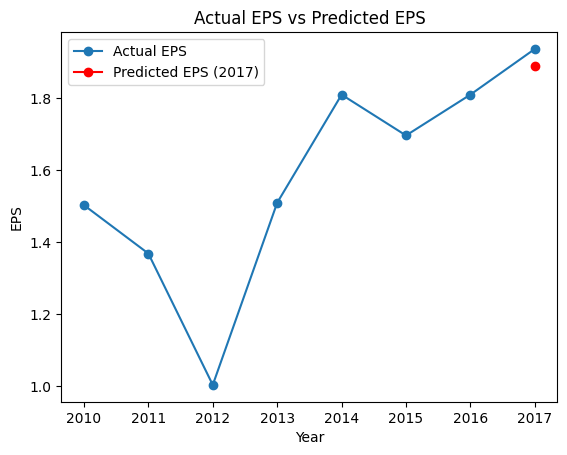

In [ ]:
# 繪製平均 EPS 圖
years = range(2010, 2018)
actual_eps = input_data.iloc[:, -8:].mean(axis=0)
predicted_eps = [0, 0, 0, 0, 0, 0, 0, np.mean(pred_rf_test)]
plt.plot(years, actual_eps, marker='o', label='Actual EPS')
plt.plot(years[-1], predicted_eps[-1], marker='o', color='red', label='Predicted EPS (2017)')
plt.xlabel('Year')
plt.ylabel('EPS')
plt.title('Actual EPS vs Predicted EPS')
plt.legend()
plt.show()

#### 5.1.2 XGBoost

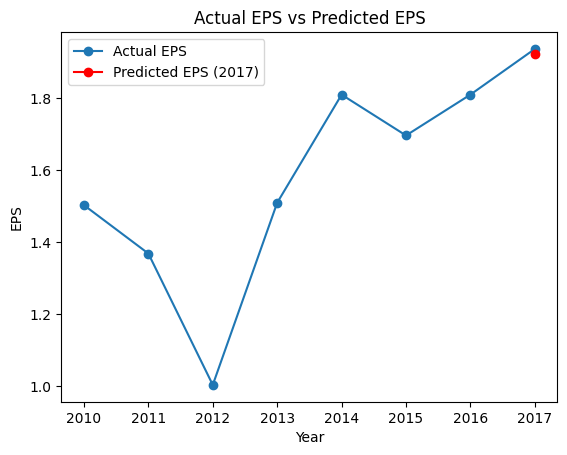

In [ ]:
# 繪製平均 EPS 圖
years = range(2010, 2018)
actual_eps = input_data.iloc[:, -8:].mean(axis=0)
predicted_eps = [0, 0, 0, 0, 0, 0, 0, np.mean(pred_xgb_test)]
plt.plot(years, actual_eps, marker='o', label='Actual EPS')
plt.plot(years[-1], predicted_eps[-1], marker='o', color='red', label='Predicted EPS (2017)')
plt.xlabel('Year')
plt.ylabel('EPS')
plt.title('Actual EPS vs Predicted EPS')
plt.legend()
plt.show()

#### 5.1.3 兩模型比較

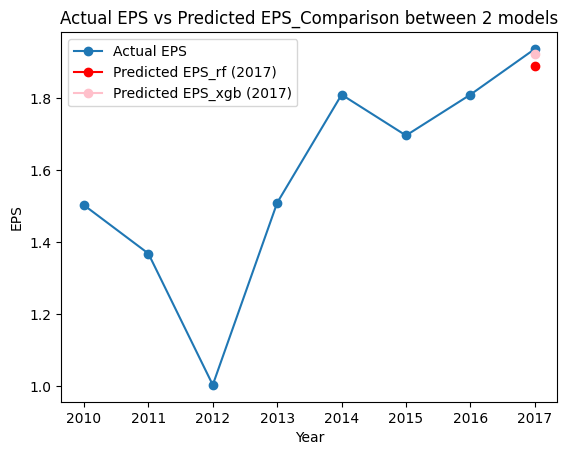

In [ ]:
# 繪製平均 EPS 圖
years = range(2010, 2018)
actual_eps = input_data.iloc[:, -8:].mean(axis=0)
predicted_eps_rf = [0, 0, 0, 0, 0, 0, 0, np.mean(pred_rf_test)]
predicted_eps_xgb = [0, 0, 0, 0, 0, 0, 0, np.mean(pred_xgb_test)]
plt.plot(years, actual_eps, marker='o', label='Actual EPS')
plt.plot(years[-1], predicted_eps_rf[-1], marker='o', color='red', label='Predicted EPS_rf (2017)')
plt.plot(years[-1], predicted_eps_xgb[-1], marker='o', color='pink', label='Predicted EPS_xgb (2017)')
plt.xlabel('Year')
plt.ylabel('EPS')
plt.title('Actual EPS vs Predicted EPS_Comparison between 2 models')
plt.legend()
plt.show()

### 5.2 預測分數

衡量指標：

*   RMSE (Root Mean Square Error)

  $RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n(\hat{y}_i - y_i)^2}$

<br>

*   MAE (Mean Absolute Error)

  $MAE = \frac{1}{n}\sum_{i=1}^n|\hat{y}_i - y_i|$

#### 5.2.1 預測分數呈現

In [ ]:
# 預測分數呈現
# --------------------- RF -------------------- 
# Random Forest 訓練集的 RMSE
rmse_rf_train = mean_squared_error(ytrain2, pred_rf_train)

# Random Forest 測試集的 RMSE
rmse_rf_test = mean_squared_error(ytest2, pred_rf_test)

# Random Forest 訓練集的 MAE
mae_rf_train = mean_absolute_error(ytrain2, pred_rf_train)

# Random Forest 測試集的 MAE
mae_rf_test = mean_absolute_error(ytest2, pred_rf_test)

# --------------------- XGB --------------------   

# XGBoost 訓練集的 RMSE
rmse_xgb_train = mean_squared_error(ytrain2, pred_xgb_train)

# XGBoost 測試集的 RMSE
rmse_xgb_test = mean_squared_error(ytest2, pred_xgb_test)

# XGBoost 訓練集的 MAE
mae_xgb_train = mean_absolute_error(ytrain2, pred_xgb_train)

# XGBoost 測試集的 MAE
mae_xgb_test = mean_absolute_error(ytest2, pred_xgb_test)

# ------------------ 兩模型衡量 -----------------   
scores = {
    'Model': ['Random Forest', 'XGBoost'],
    'RMSE Train': [rmse_rf_train, rmse_xgb_train],
    'RMSE Test': [rmse_rf_test, rmse_xgb_test],
    'MAE Train': [mae_rf_train, mae_xgb_train],
    'MAE Test': [mae_rf_test, mae_xgb_test]
}

scores_df = pd.DataFrame(scores)
scores_df

,Model,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Random Forest,1.499598,10.509613,0.542761,1.522264
1,XGBoost,1.038993,7.484186,0.719341,1.453239


#### 5.2.2 兩模型比較

##### 5.2.2.1 RMSE

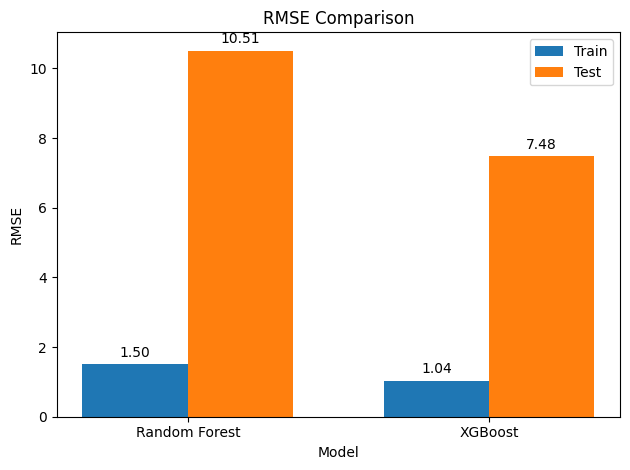

In [ ]:
# RMSE 比較圖

rmse_train = [rmse_rf_train, rmse_xgb_train]
rmse_test = [rmse_rf_test, rmse_xgb_test]

models = ['Random Forest', 'XGBoost']
bar_width = 0.35

fig, ax = plt.subplots()

# Positioning the bars for train data
bar_train = ax.bar(np.arange(len(models)), rmse_train, bar_width, label='Train')

# Positioning the bars for test data to the right of the train data
bar_test = ax.bar(np.arange(len(models)) + bar_width, rmse_test, bar_width, label='Test')

# Add value labels
for rect in bar_train + bar_test:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.xticks(np.arange(len(models)) + bar_width / 2, models)  # Adjust x-axis ticks position
plt.legend()
plt.tight_layout()
plt.show()


##### 5.2.2.2 MAE

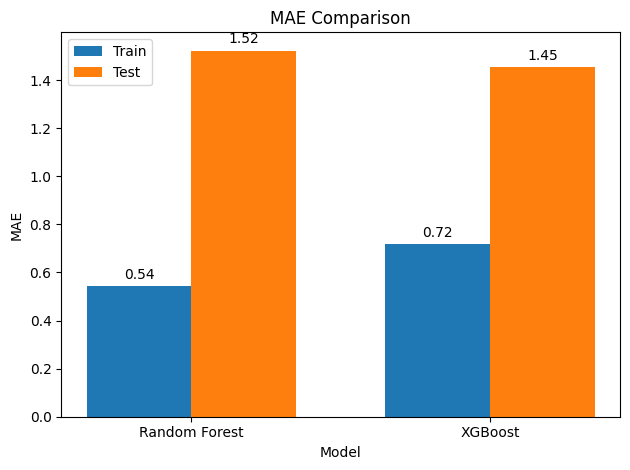

In [ ]:
# MAE 比較圖

mae_train = [mae_rf_train, mae_xgb_train]
mae_test = [mae_rf_test, mae_xgb_test]

models = ['Random Forest', 'XGBoost']
bar_width = 0.35

fig, ax = plt.subplots()

# Positioning the bars for train data
bar_train = ax.bar(np.arange(len(models)), mae_train, bar_width, label='Train')

# Positioning the bars for test data to the right of the train data
bar_test = ax.bar(np.arange(len(models)) + bar_width, mae_test, bar_width, label='Test')

# Add value labels
for rect in bar_train + bar_test:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('MAE Comparison')
plt.xticks(np.arange(len(models)) + bar_width / 2, models)  # Adjust x-axis ticks position
plt.legend()
plt.tight_layout()
plt.show()


### 5.3 變數重要性

#### 5.3.1 Random Forest

In [ ]:
# 繪製變數重要性function
def plot_importance(tree):
    # 下面這句是設定字型，因為變數是中文，但是python畫圖的default字體會沒辦法顯示中文，所以要先指定
    # 可參考上方教學網址及字體下載網址(範例使用STHeiti Light)
    font = FontProperties(fname=os.path.join(project_path, 'STHeiti Light.ttc'),size=14)
    # 讓變數為key，對應重要性(gini importance)為value
    importance_dict = {}
    for col, gini in zip(tree.feature_names_in_,tree.feature_importances_):
        importance_dict[col] = gini
    
    # 刪去重要性為0的變數，不用畫在圖上
    for var in tree.feature_names_in_:
        if importance_dict[var]==0:
            importance_dict.pop(var)
    
    # 根據重要性由小到大，排列出變數
    sort_col = sorted(importance_dict.items(), key=lambda x:x[1])
    # 取前10高重要性變數
    sort_col_top10 = sort_col[-10:]
    account = [a for (a, i) in sort_col_top10]
    importance = [i for (a, i) in sort_col_top10]

    # Plot 
    plt.title("Feature importances(Random Forest): Gini index")
    plt.barh(account, importance, color="b")
    plt.yticks(range(len(account)), account, fontproperties=font, fontsize=15)
    
    # 增添標籤，在每個bar前方增加該變數的重要性
    for a,b in zip(range(len(importance)), importance):
        plt.text(b+0.0015, a, '%.3f' % b, ha='center', va= 'center', fontsize=10)
    plt.xlim([0,max(importance)+0.005])
    plt.show()

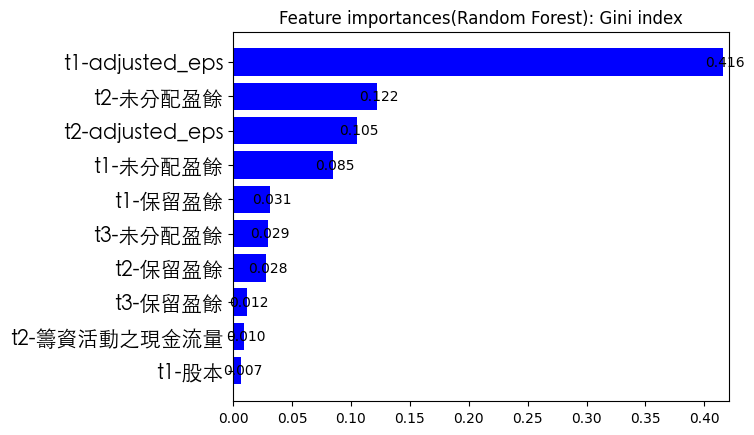

In [ ]:
plot_importance(best_rf)

#### 5.3.2 XGBoost

In [ ]:
# 繪製變數重要性function
def plot_importance_xgb(train, model):
    # 下面這句是設定字型，因為變數是中文，但是python畫圖的default字體會沒辦法顯示中文，所以要先指定
    # 可參考上方教學網址及字體下載網址(範例使用STHeiti Light)
    font = FontProperties(fname=os.path.join(project_path, 'STHeiti Light.ttc'),size=14)
    # 讓變數為key，對應重要性(gini importance)為value
    importance_dict = {}
    for col, gini in zip(train.columns ,model.feature_importances_):
        importance_dict[col] = gini
    
    # 根據重要性由小到大，排列出變數
    sort_col = sorted(importance_dict.items(), key=lambda x:x[1])
    # 取前10高重要性變數
    sort_col_top10 = sort_col[-10:]
    account = [a for (a, i) in sort_col_top10]
    importance = [i for (a, i) in sort_col_top10]

    # Plot 
    plt.title("Feature importances(XGBoost): Gini index")
    plt.barh(account, importance, color="b")
    plt.yticks(range(len(account)), account, fontproperties=font, fontsize=15)
    
    # 增添標籤，在每個bar前方增加該變數的重要性
    for a,b in zip(range(len(importance)), importance):
        plt.text(b+0.0015, a, '%.3f' % b, ha='center', va= 'center', fontsize=10)
    plt.xlim([0,max(importance)+0.005])
    plt.show()

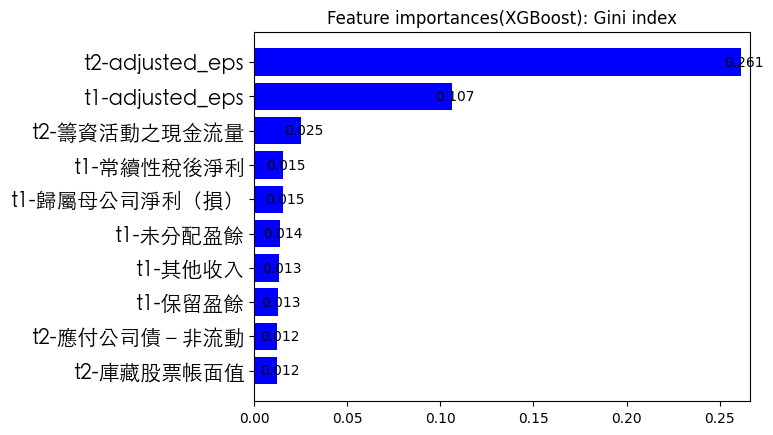

In [ ]:
plot_importance_xgb(xtrain2, best_xgb)

---------------------------------------------------------

# **第二部分：根據模型衡量結果建立投資組合並提供投資建議**

1. 已知 EPS 為衡量個股表現的重要指標，可反映公司盈利能力。
2. 假定現在時間為 2017 年初，將根據上述對於 2017 EPS 模型預測及分析結果，提供基本面投資決策建議。
3. 由第一部分已知 XGBoost 模型表現較佳，因此此部分採用 XGBoost 預測結果。 
4. 選定 5 種產業、各 2 間公司進行分析，如下所列:
- 半導體產業
    - 2330 台積電
    - 2303 聯電
- 航運業
    - 2603 長榮
    - 2606 裕民
- 電腦及周邊
    - 2353 宏碁 
    - 2357 華碩
- 通訊網路業
    - 3045 台灣大
    - 2412 中華電
- 光電業
    - 3008 大立光
    - 3481 群創






## **1.選定 10 間公司作為分析標的**

根據Ou and Penman (1989)，在計算每股盈餘的增長時，需要將前四年的趨勢納入考量，也就是說，當公司當年的每股盈餘的增長大過於前四年的平均增額才叫增加。預期的EPS為前一年的實際值加上前三年的平均增長，而當年EPS的增長（$\Delta{EPS_t}$）為當年的EPS減掉預期的EPS。


$$ Expected\;EPS_t = EPS_{t-1} + \frac{EPS_{t-1}-EPS_{t-4}}{t}$$
$$\Delta{EPS_t} = EPS_t - Expected\;EPS_t$$

因設定現在時點為 2017 年初 (t = 2017)，因此分析方式為:
1. 取出 2013 EPS (t-4)、 2016 EPS (t-1) 實際值及 2017 EPS (t) 預測值。
2. 透過以上公式計算 2017 年 Expected EPS
3. 2017 EPS 預測值 - Expected EPS 得 EPS 預期增額_delta EPS
2. 推測 EPS 增長可有較高的預期股價，因此根據求得的 delta EPS 來建立投資組合。

In [ ]:
# 取出選定的 10 間公司的 eps 資料
target_companies = ['2330 台積電', '2303 聯電', '2603 長榮', '2606 裕民', '2353 宏碁', '2357 華碩', '3045 台灣大', '2412 中華電', '3008 大立光', '3481 群創']

# Extract data for target companies
targets_xgb = xgb_result.loc[target_companies]
targets = targets_xgb[['2013_adjusted_eps','2016_adjusted_eps','2017_predicted_eps']]
# Print the selected rows
targets

,2013_adjusted_eps,2016_adjusted_eps,2017_predicted_eps
公司,,,
2330 台積電,7.260000,12.890000,13.945737
2303 聯電,1.010000,0.680000,0.599491
2603 長榮,-0.396189,-1.749496,-1.480059
2606 裕民,1.830000,-1.040000,-0.996257
2353 宏碁,-7.446315,-1.620000,-1.104126
2357 華碩,28.660000,25.850000,23.630110
3045 台灣大,5.790000,5.630000,4.672937
2412 中華電,5.120000,5.160000,5.047481
3008 大立光,71.640000,169.470000,170.249771


## **2.計算 EPS 預期增額 (delta EPS)**

使用上述公式，根據 2013 EPS 實際值、2016 EPS 實際值與 2017 EPS 預測值求算各公司預期 EPS 及 EPS 預期增額_delta EPS

In [ ]:
# 計算 delta EPS

targets['Expected EPS'] = targets['2016_adjusted_eps'] + (targets['2016_adjusted_eps'] - targets['2013_adjusted_eps']) / 3
targets['漲幅_delta EPS'] = targets['2017_predicted_eps'] - targets['Expected EPS']

targets

,2013_adjusted_eps,2016_adjusted_eps,2017_predicted_eps,Expected EPS,漲幅_delta EPS
公司,,,,,
2330 台積電,7.260000,12.890000,13.945737,14.766667,-0.820930
2303 聯電,1.010000,0.680000,0.599491,0.570000,0.029491
2603 長榮,-0.396189,-1.749496,-1.480059,-2.200598,0.720540
2606 裕民,1.830000,-1.040000,-0.996257,-1.996667,1.000410
2353 宏碁,-7.446315,-1.620000,-1.104126,0.322105,-1.426231
2357 華碩,28.660000,25.850000,23.630110,24.913333,-1.283224
3045 台灣大,5.790000,5.630000,4.672937,5.576667,-0.903729
2412 中華電,5.120000,5.160000,5.047481,5.173333,-0.125853
3008 大立光,71.640000,169.470000,170.249771,202.080000,-31.830229


## **3.建立投資組合**

得知投資組合中的個股數量及名稱後，以漲幅決定各公司在投資組合當中的比重。
1. 取出 EPS 漲幅 (delta EPS) 大於零的公司納入投資組合
2. 計算投資組合中所有公司 EPS 漲幅的總和
3. 計算各公司 EPS 漲幅佔總漲幅的比例，決定投資佔比

In [ ]:
# 選取漲幅大於0的公司
positive_growth = targets[targets['漲幅_delta EPS'] > 0]
positive_growth 

,2013_adjusted_eps,2016_adjusted_eps,2017_predicted_eps,Expected EPS,漲幅_delta EPS
公司,,,,,
2303 聯電,1.010000,0.680000,0.599491,0.570000,0.029491
2603 長榮,-0.396189,-1.749496,-1.480059,-2.200598,0.720540
2606 裕民,1.830000,-1.040000,-0.996257,-1.996667,1.000410
3481 群創,0.563361,0.190000,0.862305,0.065546,0.796758


In [ ]:
# 計算所有漲幅的總和，以便計算權重
total_growth = positive_growth['漲幅_delta EPS'].sum()

# 計算每個公司的權重
positive_growth['投資佔比'] = positive_growth['漲幅_delta EPS'] / total_growth * 100
positive_growth['投資佔比'] = positive_growth['投資佔比'].apply(lambda x: f"{x:.2f}%")  # 投資佔比以百分比呈現

positive_growth[['2016_adjusted_eps', '2017_predicted_eps', '漲幅_delta EPS', '投資佔比']]


,2016_adjusted_eps,2017_predicted_eps,漲幅_delta EPS,投資佔比
公司,,,,
2303 聯電,0.680000,0.599491,0.029491,1.16%
2603 長榮,-1.749496,-1.480059,0.720540,28.29%
2606 裕民,-1.040000,-0.996257,1.000410,39.27%
3481 群創,0.190000,0.862305,0.796758,31.28%


## **4.投資建議**

根據 XGBoost 進行模型訓練時的前十重要變數，可知基本面投資人在進行投資標的考量時，可以重點參考這些變數。

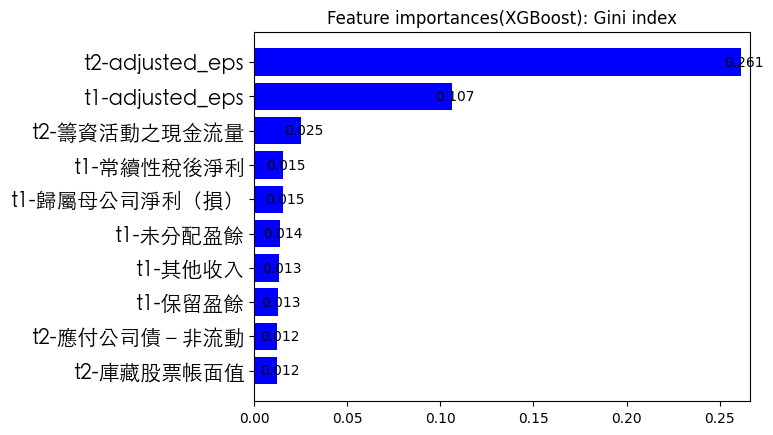

In [ ]:
plot_importance_xgb(xtrain2, best_xgb)

--------------------------------------------------------------------------

# **第三部分：鎖定產業進行預測，並分析預測結果**

1. 鎖定半導體產業進行分析
2. 分析方法、模型及預測時間範圍同第一部分

## **0. 讀取 TSE 資料**

In [ ]:
industry = pd.read_excel(os.path.join(project_path, 'TSE industry.xlsx'))
display(industry)

,公司簡稱,TSE 產業別,TSE新產業_名稱
0,1101 台泥,1,水泥工業
1,1102 亞泥,1,水泥工業
2,1103 嘉泥,1,水泥工業
3,1104 環泥,1,水泥工業
4,1108 幸福,1,水泥工業
...,...,...,...
1783,9949 琉園,32,文化創意業
1784,9950 萬國通,3,塑膠工業
1785,9951 皇田,5,電機機械
1786,9960 邁達康,18,貿易百貨


## **1.選定半導體產業作為分析標的**

In [ ]:
# 複製資料 (org_data 為去除排除金融業、生技醫療、建材營造、DR和KY公司後的原始資料)
data_semi = input_data.copy()

# 刪除所有非「半導體」的產業
company_list = industry[(industry['TSE新產業_名稱'] != '半導體')]['公司簡稱'].tolist()
company_filter = data_semi.index.isin(company_list)
data_semi = data_semi.loc[~company_filter,:]

In [ ]:
# 確認資料欄位
print("Data shape:", data_semi.shape)
print("Data size:", data_semi.size)

Data shape: (152, 653)
Data size: 99256


## **2.取得訓練和測試資料**

使用標籤年度的前兩年的3個資產負債表（期初以及期末）以及2個損益表及2個現金流量表資料為訓練資料集，以2015以及2016的每股盈餘金額為標籤。最終，利用2014-2016的3個資產負債表以及2015-2016的2個損益表及2個現金流量表資料去預測2017的每股盈餘金額。

In [ ]:
account_name = list(set(['_'.join(col.split('_')[1:]) for col in data_semi.columns]))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

tmp = pd.DataFrame(index=data_semi.index)
years = [2015, 2016]                                                            #年度調整 (預測2017)
for num, year in enumerate(years):
    for acc in account_name:
        if acc in bs_account: # bs_account為資產負債表中的科目
            # tmp["t4-"+acc] = data_semi[str(year-4)+"_"+acc]
            tmp["t3-"+acc] = data_semi[str(year-3)+"_"+acc]
            tmp["t2-"+acc] = data_semi[str(year-2)+"_"+acc]
            tmp["t1-"+acc] = data_semi[str(year-1)+"_"+acc]
        else:
            # tmp["t3-"+acc] = data_semi[str(year-3)+"_"+acc]
            tmp["t2-"+acc] = data_semi[str(year-2)+"_"+acc]
            tmp["t1-"+acc] = data_semi[str(year-1)+"_"+acc]
        tmpy = data_semi[str(year)+"_adjusted_eps"]
        # tmpy = eps_indicator.loc[data_semi.index][str(year)+"_I_eps"].copy()
    if num==len(years)-1:
        xtrain_semi = pd.concat([xtrain_semi, tmp], axis=0)
        ytrain_semi= pd.concat([ytrain_semi, tmpy], axis=0)
    else:
        xtrain_semi = tmp.copy()  
        ytrain_semi = tmpy.copy()

In [ ]:
warnings.filterwarnings('ignore')

xtest_semi = pd.DataFrame(index=data_semi.index)
year = 2017                                                                     #年度調整 (預測2017)
for acc in account_name:
    if acc in bs_account: # bs_account為資產負債表中的科目
        # xtest2["t4-"+acc] = data_semi[str(year-4)+"_"+acc]
        xtest_semi["t3-"+acc] = data_semi[str(year-3)+"_"+acc]
        xtest_semi["t2-"+acc] = data_semi[str(year-2)+"_"+acc]
        xtest_semi["t1-"+acc] = data_semi[str(year-1)+"_"+acc]
    else:
        # xtest_semi["t3-"+acc] = data_semi[str(year-3)+"_"+acc]
        xtest_semi["t2-"+acc] = data_semi[str(year-2)+"_"+acc]
        xtest_semi["t1-"+acc] = data_semi[str(year-1)+"_"+acc]
ytest_semi = data_semi[str(year)+"_adjusted_eps"].copy()

## **3. 訓練模型**

### 3.1 Random Forest

In [ ]:
# 找 Random Forest 最佳模型
best_rf_semi = search_best_model('rf', xtrain_semi, ytrain_semi, 5)

In [ ]:
# 模型訓練
best_rf_semi.fit(xtrain_semi, ytrain_semi)

RandomForestRegressor(n_jobs=-1, random_state=0)

### 3.2 XGBoost

In [ ]:
# 找 Random Forest 最佳模型
best_xgb_semi = search_best_model('xgb', xtrain_semi, ytrain_semi, 5)

In [ ]:
best_xgb_semi.fit(xtrain_semi, ytrain_semi)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

## **4.預測並衡量結果**


### 4.1 Random Forest

In [ ]:
# 預測值
pred_rf_train_semi = best_rf.predict(xtrain_semi)
pred_rf_test_semi = best_rf.predict(xtest_semi)

In [ ]:
# 預測分數

# 計算訓練集的 RMSE
rmse_rf_train_semi = mean_squared_error(ytrain_semi, pred_rf_train_semi)
print("Random Forest 訓練集的 RMSE:", rmse_rf_train_semi)

# 計算測試集的 RMSE
rmse_rf_test_semi = mean_squared_error(ytest_semi, pred_rf_test_semi)
print("Random Forest 測試集的 RMSE:", rmse_rf_test_semi)

# 計算訓練集的 MAE
mae_rf_train_semi = mean_absolute_error(ytrain_semi, pred_rf_train_semi)
print("Random Forest 訓練集的 MAE:", mae_rf_train_semi)

# 計算測試集的 MAE
mae_rf_test_semi = mean_absolute_error(ytest_semi, pred_rf_test_semi)
print("Random Forest 測試集的 MAE:", mae_rf_test_semi)

Random Forest 訓練集的 RMSE: 2.33652972340643
Random Forest 測試集的 RMSE: 5.231526601013224
Random Forest 訓練集的 MAE: 0.6511019104444075
Random Forest 測試集的 MAE: 1.5033155109493417


In [ ]:
# 變數重要性
feature_importance_rf_semi = np.round(best_rf_semi.feature_importances_, 4) 

### 4.2 XGBoost

In [ ]:
# 預測值
pred_xgb_train_semi = best_xgb.predict(xtrain_semi)
pred_xgb_test_semi = best_xgb.predict(xtest_semi)

In [ ]:
# 預測分數

# 計算訓練集的 RMSE
rmse_xgb_train_semi = mean_squared_error(ytrain_semi, pred_xgb_train_semi)
print("XGBoost 訓練集的 RMSE:", rmse_xgb_train_semi)

# 計算測試集的 RMSE
rmse_xgb_test_semi = mean_squared_error(ytest_semi, pred_xgb_test_semi)
print("XGBoost 測試集的 RMSE:", rmse_xgb_test_semi)

# 計算訓練集的 MAE
mae_xgb_train_semi = mean_absolute_error(ytrain_semi, pred_xgb_train_semi)
print("XGBoost 訓練集的 MAE:", mae_xgb_train_semi)

# 計算測試集的 MAE
mae_xgb_test_semi = mean_absolute_error(ytest_semi, pred_xgb_test_semi)
print("XGBoost 測試集的 MAE:", mae_xgb_test_semi)

XGBoost 訓練集的 RMSE: 1.0618267366432237
XGBoost 測試集的 RMSE: 4.580702416333027
XGBoost 訓練集的 MAE: 0.7195662184538104
XGBoost 測試集的 MAE: 1.4446443084575455


In [ ]:
# 變數重要性
feature_importance_xgb_semi = np.round(best_xgb_semi.feature_importances_, 4) 

## **5.視覺化呈現**

In [ ]:
# Random Forest 實際 & 預測 EPS
rf_result_semi = data_semi.iloc[:, -8:] 
rf_result_semi['2017_predicted_eps'] = pd.DataFrame(pred_rf_test_semi).values  
rf_result_semi.head()

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps,2017_predicted_eps
公司,,,,,,,,,
1439 中和,21.680000,-0.870000,-0.090000,0.020000,0.010000,0.010000,0.280000,-0.07000,0.152099
1443 立益,0.172164,-1.500000,-2.290000,-0.610000,-1.510000,-0.890000,-1.340000,-1.79000,0.194258
1507 永大,3.300000,3.610000,3.790000,4.190000,4.950000,4.530000,3.800000,2.76000,4.049088
1529 樂士,-19.089014,-0.384859,-7.851127,-2.540070,-1.924296,-5.541972,-1.308521,0.84669,-1.689918
2302 麗正,0.236514,-0.481069,-1.077596,0.153942,0.717750,0.030000,0.080000,-0.20000,0.104780


In [ ]:
# Random Forest 預測 EPS
pd.DataFrame(rf_result_semi['2017_predicted_eps']).head(10)

,2017_predicted_eps
公司,
1439 中和,0.152099
1443 立益,0.194258
1507 永大,4.049088
1529 樂士,-1.689918
2302 麗正,0.104780
2303 聯電,0.541970
2329 華泰,0.238889
2330 台積電,12.732511
2337 旺宏,-0.740788


In [ ]:
# XGBoost 實際 & 預測 EPS
xgb_result_semi = data_semi.iloc[:, -8:] 
xgb_result_semi['2017_predicted_eps'] = pd.DataFrame(pred_xgb_test_semi).values  
xgb_result_semi.head()

,2010_adjusted_eps,2011_adjusted_eps,2012_adjusted_eps,2013_adjusted_eps,2014_adjusted_eps,2015_adjusted_eps,2016_adjusted_eps,2017_adjusted_eps,2017_predicted_eps
公司,,,,,,,,,
1439 中和,21.680000,-0.870000,-0.090000,0.020000,0.010000,0.010000,0.280000,-0.07000,-0.069902
1443 立益,0.172164,-1.500000,-2.290000,-0.610000,-1.510000,-0.890000,-1.340000,-1.79000,0.807088
1507 永大,3.300000,3.610000,3.790000,4.190000,4.950000,4.530000,3.800000,2.76000,3.720607
1529 樂士,-19.089014,-0.384859,-7.851127,-2.540070,-1.924296,-5.541972,-1.308521,0.84669,0.026420
2302 麗正,0.236514,-0.481069,-1.077596,0.153942,0.717750,0.030000,0.080000,-0.20000,0.319763


In [ ]:
# XGBoost 預測 EPS
pd.DataFrame(xgb_result_semi['2017_predicted_eps']).head(10)

,2017_predicted_eps
公司,
1439 中和,-0.069902
1443 立益,0.807088
1507 永大,3.720607
1529 樂士,0.026420
2302 麗正,0.319763
2303 聯電,0.599491
2329 華泰,0.664288
2330 台積電,13.945737
2337 旺宏,-0.733910


### 5.1 預測金額圖

#### 5.1.1 Random Forest

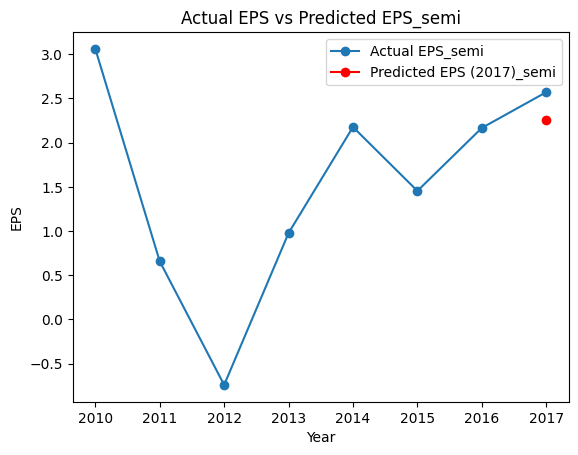

In [ ]:
# 繪製平均 EPS 圖
years = range(2010, 2018)
actual_eps_semi = data_semi.iloc[:, -8:].mean(axis=0)
predicted_eps_semi = [0, 0, 0, 0, 0, 0, 0, np.mean(pred_rf_test_semi)]
plt.plot(years, actual_eps_semi, marker='o', label='Actual EPS_semi')
plt.plot(years[-1], predicted_eps_semi[-1], marker='o', color='red', label='Predicted EPS (2017)_semi')
plt.xlabel('Year')
plt.ylabel('EPS')
plt.title('Actual EPS vs Predicted EPS_semi')
plt.legend()
plt.show()

#### 5.1.2 XGBoost

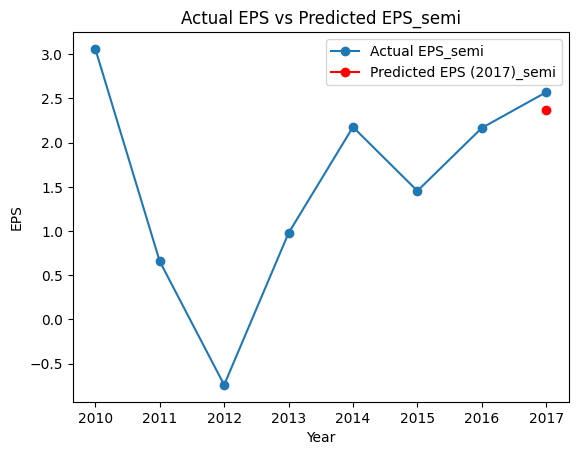

In [ ]:
# 繪製平均 EPS 圖
years = range(2010, 2018)
actual_eps_semi = data_semi.iloc[:, -8:].mean(axis=0)
predicted_eps_semi = [0, 0, 0, 0, 0, 0, 0, np.mean(pred_xgb_test_semi)]
plt.plot(years, actual_eps_semi, marker='o', label='Actual EPS_semi')
plt.plot(years[-1], predicted_eps_semi[-1], marker='o', color='red', label='Predicted EPS (2017)_semi')
plt.xlabel('Year')
plt.ylabel('EPS')
plt.title('Actual EPS vs Predicted EPS_semi')
plt.legend()
plt.show()

#### 5.1.3 兩模型比較

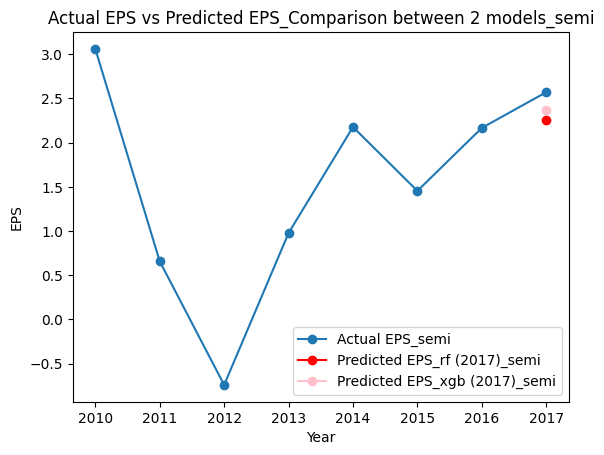

In [ ]:
# 繪製平均 EPS 圖
years = range(2010, 2018)
actual_eps_semi = data_semi.iloc[:, -8:].mean(axis=0)
predicted_eps_rf_semi = [0, 0, 0, 0, 0, 0, 0, np.mean(pred_rf_test_semi)]
predicted_eps_xgb_semi = [0, 0, 0, 0, 0, 0, 0, np.mean(pred_xgb_test_semi)]
plt.plot(years, actual_eps_semi, marker='o', label='Actual EPS_semi')
plt.plot(years[-1], predicted_eps_rf_semi[-1], marker='o', color='red', label='Predicted EPS_rf (2017)_semi')
plt.plot(years[-1], predicted_eps_xgb_semi[-1], marker='o', color='pink', label='Predicted EPS_xgb (2017)_semi')
plt.xlabel('Year')
plt.ylabel('EPS')
plt.title('Actual EPS vs Predicted EPS_Comparison between 2 models_semi')
plt.legend()
plt.show()

### 5.2 預測分數圖

衡量指標：

*   RMSE (Root Mean Square Error)

  $RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n(\hat{y}_i - y_i)^2}$

<br>

*   MAE (Mean Absolute Error)

  $MAE = \frac{1}{n}\sum_{i=1}^n|\hat{y}_i - y_i|$

#### 5.2.1 預測分數呈現

In [ ]:
# 預測分數呈現
# --------------------- RF -------------------- 
# Random Forest 訓練集的 RMSE
rmse_rf_train_semi = mean_squared_error(ytrain_semi, pred_rf_train_semi)

# Random Forest 測試集的 RMSE
rmse_rf_test_semi = mean_squared_error(ytest_semi, pred_rf_test_semi)

# Random Forest 訓練集的 MAE
mae_rf_train_semi = mean_absolute_error(ytrain_semi, pred_rf_train_semi)

# Random Forest 測試集的 MAE
mae_rf_test_semi = mean_absolute_error(ytest_semi, pred_rf_test_semi)

# --------------------- XGB --------------------   

# XGBoost 訓練集的 RMSE
rmse_xgb_train_semi = mean_squared_error(ytrain_semi, pred_xgb_train_semi)

# XGBoost 測試集的 RMSE
rmse_xgb_test_semi = mean_squared_error(ytest_semi, pred_xgb_test_semi)

# XGBoost 訓練集的 MAE
mae_xgb_train_semi = mean_absolute_error(ytrain_semi, pred_xgb_train_semi)

# XGBoost 測試集的 MAE
mae_xgb_test_semi = mean_absolute_error(ytest_semi, pred_xgb_test_semi)

# ------------------ 兩模型衡量 -----------------   
scores_semi = {
    'Model': ['Random Forest', 'XGBoost'],
    'RMSE Train': [rmse_rf_train_semi, rmse_xgb_train_semi],
    'RMSE Test': [rmse_rf_test_semi, rmse_xgb_test_semi],
    'MAE Train': [mae_rf_train_semi, mae_xgb_train_semi],
    'MAE Test': [mae_rf_test_semi, mae_xgb_test_semi]
}

scores_df_semi = pd.DataFrame(scores_semi)
scores_df_semi

,Model,RMSE Train,RMSE Test,MAE Train,MAE Test
0,Random Forest,2.336530,5.231527,0.651102,1.503316
1,XGBoost,1.061827,4.580702,0.719566,1.444644


#### 5.2.2 兩模型比較

##### 5.2.2.1 RMSE

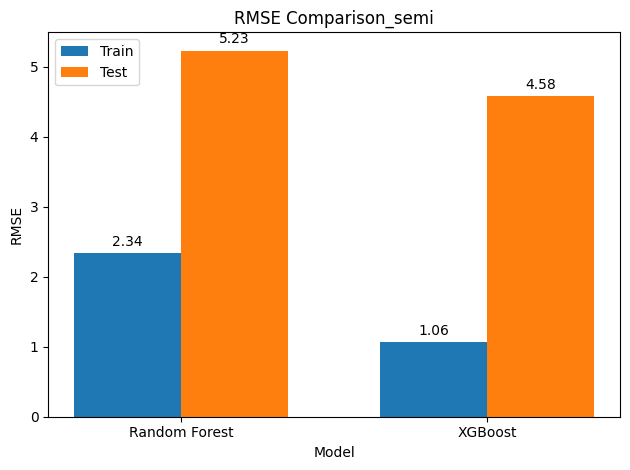

In [ ]:
# RMSE 比較圖

rmse_train_semi = [rmse_rf_train_semi, rmse_xgb_train_semi]
rmse_test_semi = [rmse_rf_test_semi, rmse_xgb_test_semi]

models = ['Random Forest', 'XGBoost']
bar_width = 0.35

fig, ax = plt.subplots()

# Positioning the bars for train data
bar_train = ax.bar(np.arange(len(models)), rmse_train_semi, bar_width, label='Train')

# Positioning the bars for test data to the right of the train data
bar_test = ax.bar(np.arange(len(models)) + bar_width, rmse_test_semi, bar_width, label='Test')

# Add value labels
for rect in bar_train + bar_test:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison_semi')
plt.xticks(np.arange(len(models)) + bar_width / 2, models)  # Adjust x-axis ticks position
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


##### 5.2.2.2 MAE

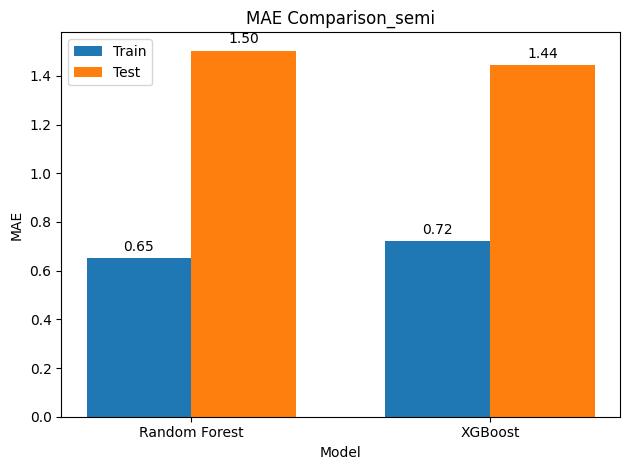

In [ ]:
# MAE 比較圖

mae_train_semi = [mae_rf_train_semi, mae_xgb_train_semi]
mae_test_semi = [mae_rf_test_semi, mae_xgb_test_semi]

models = ['Random Forest', 'XGBoost']
bar_width = 0.35

fig, ax = plt.subplots()

# Positioning the bars for train data
bar_train_semi = ax.bar(np.arange(len(models)), mae_train_semi, bar_width, label='Train')

# Positioning the bars for test data to the right of the train data
bar_test_semi = ax.bar(np.arange(len(models)) + bar_width, mae_test_semi, bar_width, label='Test')

# Add value labels
for rect in bar_train_semi + bar_test_semi:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('MAE Comparison_semi')
plt.xticks(np.arange(len(models)) + bar_width / 2, models)  # Adjust x-axis ticks position
plt.legend()
plt.tight_layout()
plt.show()


## 5.3 變數重要性

#### 5.3.1 Random Forest

In [ ]:
# 繪製變數重要性function
def plot_importance(tree):
    # 下面這句是設定字型，因為變數是中文，但是python畫圖的default字體會沒辦法顯示中文，所以要先指定
    # 可參考上方教學網址及字體下載網址(範例使用STHeiti Light)
    font = FontProperties(fname=os.path.join(project_path, 'STHeiti Light.ttc'),size=14)
    # 讓變數為key，對應重要性(gini importance)為value
    importance_dict = {}
    for col, gini in zip(tree.feature_names_in_,tree.feature_importances_):
        importance_dict[col] = gini
    
    # 刪去重要性為0的變數，不用畫在圖上
    for var in tree.feature_names_in_:
        if importance_dict[var]==0:
            importance_dict.pop(var)
    
    # 根據重要性由小到大，排列出變數
    sort_col = sorted(importance_dict.items(), key=lambda x:x[1])
    # 取前10高重要性變數
    sort_col_top10 = sort_col[-10:]
    account = [a for (a, i) in sort_col_top10]
    importance = [i for (a, i) in sort_col_top10]

    # Plot 
    plt.title("Feature importances(Random Forest): Gini index")
    plt.barh(account, importance, color="b")
    plt.yticks(range(len(account)), account, fontproperties=font, fontsize=15)
    
    # 增添標籤，在每個bar前方增加該變數的重要性
    for a,b in zip(range(len(importance)), importance):
        plt.text(b+0.0015, a, '%.3f' % b, ha='center', va= 'center', fontsize=10)
    plt.xlim([0,max(importance)+0.005])
    plt.show()

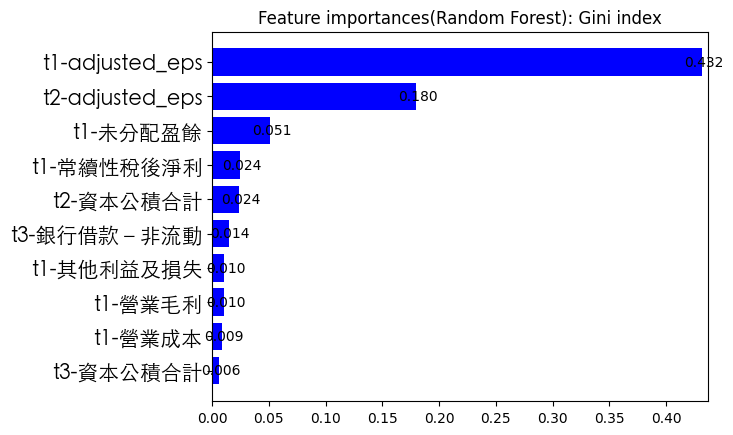

In [ ]:
plot_importance(best_rf_semi)

#### 5.3.2 XGBoost

In [ ]:
# 繪製變數重要性function
def plot_importance_xgb(train, model):
    # 下面這句是設定字型，因為變數是中文，但是python畫圖的default字體會沒辦法顯示中文，所以要先指定
    # 可參考上方教學網址及字體下載網址(範例使用STHeiti Light)
    font = FontProperties(fname=os.path.join(project_path, 'STHeiti Light.ttc'),size=14)
    # 讓變數為key，對應重要性(gini importance)為value
    importance_dict = {}
    for col, gini in zip(train.columns ,model.feature_importances_):
        importance_dict[col] = gini
    
    # 根據重要性由小到大，排列出變數
    sort_col = sorted(importance_dict.items(), key=lambda x:x[1])
    # 取前10高重要性變數
    sort_col_top10 = sort_col[-10:]
    account = [a for (a, i) in sort_col_top10]
    importance = [i for (a, i) in sort_col_top10]

    # Plot 
    plt.title("Feature importances(XGBoost): Gini index")
    plt.barh(account, importance, color="b")
    plt.yticks(range(len(account)), account, fontproperties=font, fontsize=15)
    
    # 增添標籤，在每個bar前方增加該變數的重要性
    for a,b in zip(range(len(importance)), importance):
        plt.text(b+0.0015, a, '%.3f' % b, ha='center', va= 'center', fontsize=10)
    plt.xlim([0,max(importance)+0.005])
    plt.show()

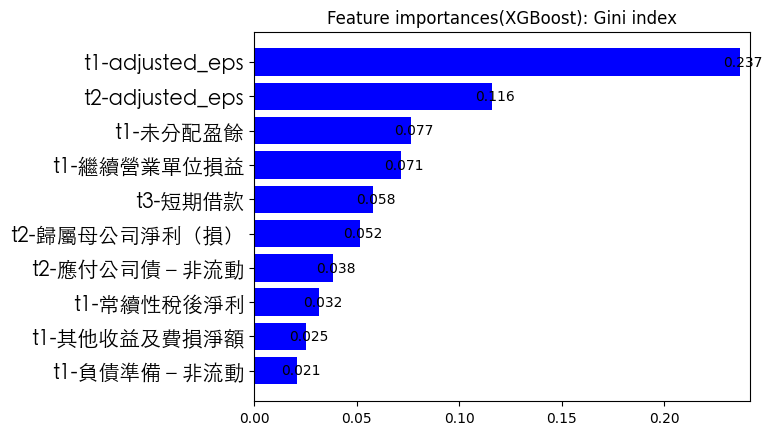

In [ ]:
plot_importance_xgb(xtrain_semi, best_xgb_semi)

------------------------------

# **第四部分：根據模型衡量結果建立半導體產業投資組合並提供投資建議**

1. 已知 EPS 為衡量個股表現的重要指標，可反映公司盈利能力。
2. 假定現在時間為 2017 年初，將根據上述對於 2017 EPS 模型預測及分析結果，提供基本面投資決策建議。
3. 由第一部分已知 XGBoost 模型表現較佳，因此此部分採用 XGBoost 預測結果。 
4. 以半導體產業所有公司作為潛在投資標的。






## **1.以半導體產業所有公司做為分析標的**

根據Ou and Penman (1989)，在計算每股盈餘的增長時，需要將前四年的趨勢納入考量，也就是說，當公司當年的每股盈餘的增長大過於前四年的平均增額才叫增加。預期的EPS為前一年的實際值加上前三年的平均增長，而當年EPS的增長（$\Delta{EPS_t}$）為當年的EPS減掉預期的EPS。


$$ Expected\;EPS_t = EPS_{t-1} + \frac{EPS_{t-1}-EPS_{t-4}}{t}$$
$$\Delta{EPS_t} = EPS_t - Expected\;EPS_t$$

因設定現在時點為 2017 年初 (t = 2017)，因此分析方式為:
1. 取出 2013 EPS (t-4)、 2016 EPS (t-1) 實際值及 2017 EPS (t) 預測值。
2. 透過以上公式計算 2017 年 Expected EPS
3. 2017 EPS 預測值 - Expected EPS 得 EPS 預期增額_delta EPS
2. 推測 EPS 增長可有較高的預期股價，因此根據求得的 delta EPS 來建立投資組合。

In [ ]:
# Print the selected rows
targets_semi = xgb_result_semi[['2013_adjusted_eps','2016_adjusted_eps','2017_predicted_eps']]
targets_semi

,2013_adjusted_eps,2016_adjusted_eps,2017_predicted_eps
公司,,,
1439 中和,0.020000,0.280000,-0.069902
1443 立益,-0.610000,-1.340000,0.807088
1507 永大,4.190000,3.800000,3.720607
1529 樂士,-2.540070,-1.308521,0.026420
2302 麗正,0.153942,0.080000,0.319763
...,...,...,...
8271 宇瞻,4.329466,2.740000,3.247528
8277 商丞,0.730000,-1.600000,-1.554878
8299 群聯,17.570000,24.670000,28.671148


## **2.計算 EPS 預期增額 (delta EPS)**

根據 2016 EPS 實際值與 2017 EPS 預測值求算各公司 EPS 預期漲幅，並取出 EPS 漲幅為正的公司納入投資組合當中



In [ ]:
# 計算 delta EPS
targets_semi['Expected EPS'] = targets_semi['2016_adjusted_eps'] + (targets_semi['2016_adjusted_eps'] - targets_semi['2013_adjusted_eps']) / 3
targets_semi['漲幅_delta EPS'] = targets_semi['2017_predicted_eps'] - targets_semi['Expected EPS']

targets_semi

,2013_adjusted_eps,2016_adjusted_eps,2017_predicted_eps,Expected EPS,漲幅_delta EPS
公司,,,,,
1439 中和,0.020000,0.280000,-0.069902,0.366667,-0.436568
1443 立益,-0.610000,-1.340000,0.807088,-1.583333,2.390421
1507 永大,4.190000,3.800000,3.720607,3.670000,0.050607
1529 樂士,-2.540070,-1.308521,0.026420,-0.898005,0.924425
2302 麗正,0.153942,0.080000,0.319763,0.055353,0.264411
...,...,...,...,...,...
8271 宇瞻,4.329466,2.740000,3.247528,2.210178,1.037350
8277 商丞,0.730000,-1.600000,-1.554878,-2.376667,0.821789
8299 群聯,17.570000,24.670000,28.671148,27.036667,1.634482


## **3. 建立半導體產業投資組合**

得知投資組合中的個股數量及名稱後，以漲幅決定各公司在投資組合當中的比重。
1. 取出 EPS 漲幅 (delta EPS) 前 10 大的公司納入投資組合
2. 計算投資組合中所有公司 EPS 漲幅的總和
3. 計算各公司 EPS 漲幅佔總漲幅的比例，決定投資佔比

In [ ]:
# 選取漲幅大於0的公司
positive_growth_semi = targets_semi[targets_semi['漲幅_delta EPS'] > 0]
positive_growth_semi 

,2013_adjusted_eps,2016_adjusted_eps,2017_predicted_eps,Expected EPS,漲幅_delta EPS
公司,,,,,
1443 立益,-0.610000,-1.340000,0.807088,-1.583333,2.390421
1507 永大,4.190000,3.800000,3.720607,3.670000,0.050607
1529 樂士,-2.540070,-1.308521,0.026420,-0.898005,0.924425
2302 麗正,0.153942,0.080000,0.319763,0.055353,0.264411
2303 聯電,1.010000,0.680000,0.599491,0.570000,0.029491
...,...,...,...,...,...
8088 品安,3.476114,1.139710,0.864483,0.360908,0.503575
8150 南茂,3.037286,1.958829,3.158805,1.599344,1.559461
8271 宇瞻,4.329466,2.740000,3.247528,2.210178,1.037350


因漲幅大於 0 的半導體產業公司間數多，因此取漲幅前 10 高的公司納入投資組合

In [ ]:
# 按照 "漲幅_delta EPS" 欄位進行降序排序
sorted_df = positive_growth_semi.sort_values("漲幅_delta EPS", ascending=False)

# 選取漲幅前 10 大的公司
top_10_semi = sorted_df.head(10)

top_10_semi

,2013_adjusted_eps,2016_adjusted_eps,2017_predicted_eps,Expected EPS,漲幅_delta EPS
公司,,,,,
3383 新世紀,-7.063621,-30.064953,-17.479498,-37.732064,20.252566
3661 世芯-KY,2.100000,-3.450000,-0.589450,-5.300000,4.710550
3041 揚智,4.793310,-3.064575,-0.989380,-5.683870,4.694490
6182 合晶,-1.354921,-3.494652,-0.331341,-4.207895,3.876554
3374 精材,1.220000,-2.360000,-1.054058,-3.553333,2.499275
1443 立益,-0.610000,-1.340000,0.807088,-1.583333,2.390421
5483 中美晶,0.570000,-2.770000,-1.832327,-3.883333,2.051006
3556 禾瑞亞,7.364885,3.230021,3.559651,1.851733,1.707919
4966 譜瑞-KY,9.250000,18.040000,22.608023,20.970000,1.638023


In [ ]:
# 3383 新世紀查無股價及交易資料，因此將其從投資組合中去除
# 移除第一列
top_9_semi = top_10_semi.iloc[1:]
top_9_semi

,2013_adjusted_eps,2016_adjusted_eps,2017_predicted_eps,Expected EPS,漲幅_delta EPS
公司,,,,,
3661 世芯-KY,2.100000,-3.450000,-0.589450,-5.300000,4.710550
3041 揚智,4.793310,-3.064575,-0.989380,-5.683870,4.694490
6182 合晶,-1.354921,-3.494652,-0.331341,-4.207895,3.876554
3374 精材,1.220000,-2.360000,-1.054058,-3.553333,2.499275
1443 立益,-0.610000,-1.340000,0.807088,-1.583333,2.390421
5483 中美晶,0.570000,-2.770000,-1.832327,-3.883333,2.051006
3556 禾瑞亞,7.364885,3.230021,3.559651,1.851733,1.707919
4966 譜瑞-KY,9.250000,18.040000,22.608023,20.970000,1.638023
8299 群聯,17.570000,24.670000,28.671148,27.036667,1.634482


In [ ]:
# 計算所有漲幅的總和，以便計算權重
total_growth_semi = top_9_semi['漲幅_delta EPS'].sum()

# 計算每個公司的權重
top_9_semi['投資佔比'] = top_9_semi['漲幅_delta EPS'] / total_growth_semi * 100
top_9_semi['投資佔比'] = top_9_semi['投資佔比'].apply(lambda x: f"{x:.2f}%")  # 投資佔比以百分比呈現

top_9_semi[['2016_adjusted_eps', '2017_predicted_eps', '漲幅_delta EPS', '投資佔比']]

,2016_adjusted_eps,2017_predicted_eps,漲幅_delta EPS,投資佔比
公司,,,,
3661 世芯-KY,-3.450000,-0.589450,4.710550,18.69%
3041 揚智,-3.064575,-0.989380,4.694490,18.63%
6182 合晶,-3.494652,-0.331341,3.876554,15.38%
3374 精材,-2.360000,-1.054058,2.499275,9.92%
1443 立益,-1.340000,0.807088,2.390421,9.48%
5483 中美晶,-2.770000,-1.832327,2.051006,8.14%
3556 禾瑞亞,3.230021,3.559651,1.707919,6.78%
4966 譜瑞-KY,18.040000,22.608023,1.638023,6.50%
8299 群聯,24.670000,28.671148,1.634482,6.49%


##**4.半導體產業投資建議**

根據 XGBoost 進行模型訓練時的前十重要變數，可知基本面投資人在進行半導體產業的投資標選擇時，可以重點參考這些變數。

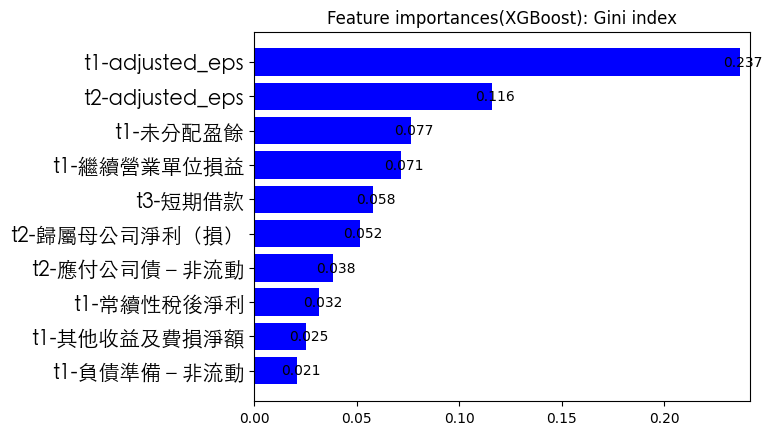

In [ ]:
plot_importance_xgb(xtrain_semi, best_xgb_semi)